In [1]:
# !pip install gensim
# !pip install wordcloud
# !pip install xgboost
# !pip install transformers
# !pip install torch
# !pip install torch torchvision torchaudio

# !pip freeze | grep -v '@' > requirements.txt
# To install libraries:
# !pip install -r requirements.txt
# !grep -v '@' requirements.txt | pip install -r /dev/stdin

In [2]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
# from joblib import Parallel, delayed
# !pip install pyLDAvis

# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [3]:
import pickle
import numpy as np
import re
import random
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS 
from gensim.models.phrases import Phrases, Phraser
from wordcloud import WordCloud
from collections import Counter
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.utils import shuffle
from gensim.models.ldamulticore import LdaMulticore# in case use multi-cores
import spacy
from spacy import displacy
from spacy import tokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from joblib import Parallel, delayed
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to /home/wenyuand/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wenyuand/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
random_state = 42

## Pre data files

### prep pkl files

In [5]:
data_directory = 'assets_2/'

In [6]:
#covert csv files to pkl file
df_youtube = pd.read_csv(f'{data_directory}youtube_parsed_dataset.csv')
df_youtube = df_youtube[['Text', 'oh_label']].rename(columns={'Text': 'text', 'oh_label': 'label'})
df_youtube.to_pickle(f'{data_directory}youtube_data.pkl')

In [7]:
df_kaggle = pd.read_csv(f'{data_directory}kaggle_parsed_dataset.csv')
df_kaggle = df_kaggle[['Text', 'oh_label']].rename(columns={'Text': 'text', 'oh_label': 'label'})
df_kaggle.to_pickle(f'{data_directory}kaggle_data.pkl')

In [8]:
data_twitter= pd.read_pickle(f'{data_directory}twitter_data.pkl')
df_twitter = pd.DataFrame(data_twitter)
df_twitter['label'] = df_twitter['label'].apply(lambda x: 1 if x in ["sexism", "racism"] else 0)
df_twitter.to_pickle(f'{data_directory}twitter_data_relabel.pkl')

### prep combined_df

In [9]:
def read_combined_pkl(files):
    """
    combine all datasources
    
    Parameters:
    - files: datasource files names

    Returns:
    - combined dataframe
    """
    dfs = []  

    for file in files:
        data= pd.read_pickle(f'{data_directory}{file}.pkl')
        df = pd.DataFrame(data)
        df['filename'] = file
        dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    return final_df

In [10]:
files = ['formspring_data','wiki_data','twitter_data_relabel','kaggle_data','youtube_data','kaggle_data']
combined_df = read_combined_pkl(files)

In [11]:
combined_df.shape

(165789, 4)

In [12]:
# overview = combined_df.groupby(['filename', 'label']).size().reset_index(name='num_records')
# print(overview)

In [13]:
def remove_duplicates(combined_df):
    duplicates_text = combined_df[combined_df.duplicated(subset=['text','filename'])]
    unique_texts = combined_df['text'].nunique()
    total_texts = len(combined_df)
    duplicate_texts = total_texts - unique_texts

#     print(f"Total texts: {total_texts}")
#     print(f"Unique texts: {unique_texts}")
#     print(f"Duplicate texts: {duplicate_texts}")
    duplicated_rows = combined_df[combined_df.duplicated(subset='text', keep=False)]
    df_sorted = combined_df.sort_values(by='label', ascending=False)
    df_cleaned = df_sorted.drop_duplicates(subset='text', keep='first')
    return df_cleaned

In [14]:
df_cleaned = remove_duplicates(combined_df)

In [15]:
def remove_userId(text):
#     text = " ".join([x.lower() for x in text.split()]) # Case Conversion
#    text = re.sub(r"\S*https?:\S*", '', text) # remove URL links
#    text = ' '.join([x for x in text.split() if not x.startswith('@')]) # remove @UserId for privacy purpose [DL]: what if the user name is not start with @? e.g. ".@aamattyhealy"
    text = re.sub(r'@(?!ck\b|cking\b)(\w+)', '@', text) # remove @UserId for privacy purpose
    return text.strip()

In [16]:
df_cleaned['text'] = df_cleaned['text'].apply(lambda x: remove_userId(str(x)))

In [17]:
df_cleaned['label'].value_counts()

label
0    134099
1     22593
Name: count, dtype: int64

## Prep and explore df

### Select df and sample data

you can select your dataframe: balance or imbalance; you can select all_sources, or [list of selected sources]

In [18]:
filename_full_list = df_cleaned.filename.unique()

In [19]:
filename_full_list

array(['kaggle_data', 'wiki_data', 'twitter_data_relabel',
       'formspring_data', 'youtube_data'], dtype=object)

In [20]:
def select_df(balance_YN, filename_list):
    
    def balance_data_stratified(df):
        """
        Balance the dataframe by keeping all rows where label=1 
        and stratified sampling based on 'filename' for label=0.

        Parameters:
        - df: Input DataFrame

        Returns:
        - Balanced DataFrame
        """
        unique_strata = df['filename'].unique()
        samples = []
        for stratum in unique_strata: 
        # Separate the dataframe based on 'label'
            pos_samples = df[(df['filename'] == stratum) & (df['label'] == 1)]
            num_samples = len(pos_samples)

            neg_samples = df[(df['filename'] == stratum) & (df['label'] == 0)].sample(num_samples, random_state=random_state)
            samples.extend(pos_samples.index.tolist())
            samples.extend(neg_samples.index.tolist())

        balanced_sample = df.loc[samples].copy()

        return balanced_sample

    if balance_YN == 'Y':
        df = balance_data_stratified(df_cleaned)
    else:
        df= df_cleaned
    df_selected = df[df['filename'].isin(filename_list)]
    return df_selected
        
        

In [21]:
balance_YN = 'Y'
filename_list =['wiki_data', 'kaggle_data', 'twitter_data_relabel',
       'formspring_data','youtube_data']
result_df = select_df(balance_YN, filename_list)

In [22]:
#function to show the distribution per file
def show_file_distribution(df):
    pivot_data = df.groupby(['filename', 'label']).size().unstack().reset_index()
    pivot_data['total_records'] = pivot_data.sum(axis=1)
    pivot_data = pivot_data.sort_values(by='total_records', ascending=False).drop(columns='total_records')
    print(pivot_data)
    pivot_data.set_index('filename').plot(kind='bar', stacked=False)
    plt.title('Number of Records per File by Label')
    plt.ylabel('Number of Records')
    plt.xlabel('Filename')
    plt.xticks(rotation=45)
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()

In [23]:
def show_file_distribution(df):
    pivot_data = df.groupby(['filename', 'label']).size().unstack().reset_index()
    pivot_data = pivot_data.fillna(0) # Fill NaN values, if any, with 0
    pivot_data['total_records'] = pivot_data.iloc[:, 1:].sum(axis=1)
    pivot_data = pivot_data.sort_values(by='total_records', ascending=False).drop(columns='total_records')
    
    print(pivot_data)
    
    pivot_data.set_index('filename').plot(kind='bar', stacked=False)
    plt.title('Number of Records per File by Label')
    plt.ylabel('Number of Records')
    plt.xlabel('Filename')
    plt.xticks(rotation=45)
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()

label              filename      0      1
3                 wiki_data  13568  13568
2      twitter_data_relabel   5054   5054
1               kaggle_data   2778   2778
0           formspring_data    776    776
4              youtube_data    417    417


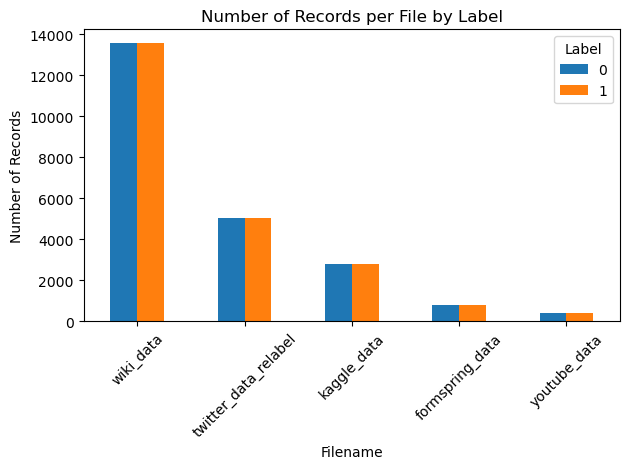

In [24]:
show_file_distribution(result_df)

## Feature engineering

### EDA


- the columns we have are only label, text, filename, we will add below features to help us understand and explore the data

    - Text length, 
    - number of hashtag, 
    - number of mentions@
    - number of capital letter pct
    - number of URL

- we will also explore df through POS (Part-of-speech) Tagging and perform sentimental analysis to understand if sentiment differs between cyberbullying and non-cyberbullying


In [27]:
# add additional columns text_len, hashtag_count, mention_count,capital_percentage
def text_len(text):
    return len(text.split())

def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

def count_mentions(text):
    return text.count('@')

def capital_percentage(text):
    if len(text) == 0:
        return 0
    return sum(1 for char in text if char.isupper()) / len(text) * 100

def count_urls(text):
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    return len(urls)

In [34]:
result_df = result_df.copy()
result_df['text_len'] = result_df['text'].apply(text_len)
result_df['hashtag_count'] = result_df['text'].apply(count_hashtags)
result_df['mention_count'] = result_df['text'].apply(count_mentions)
result_df['capital_letter_pct'] = result_df['text'].apply(capital_percentage)
result_df['url_count'] = result_df['text'].apply(count_urls)

In [35]:
result_df.filename.unique()

array(['kaggle_data', 'wiki_data', 'twitter_data_relabel',
       'formspring_data', 'youtube_data'], dtype=object)

### Visualize features to understand selected df

In [49]:
def compare_cb_non_cb_statistics(balanced_df):
    features = ['text_len', 'hashtag_count', 'mention_count','capital_letter_pct','url_count']
    cb_df = balanced_df[balanced_df['label'] == 1]
    non_cb_df= balanced_df[balanced_df['label'] == 0]
    
    print("cb_df Descriptive Stats:")
    print(cb_df[features].describe())

    print("\n non_cb_df Descriptive Stats:")
    print(non_cb_df[features].describe())

    for feature in features:
        plt.figure(figsize=(8, 4))

        # Histograms
        plt.hist(cb_df[feature], alpha=0.5,  label="Cyberbullying", color='red')
        plt.hist(non_cb_df[feature], alpha=0.5,  label="Non_Cyberbullying", color='blue')
        plt.legend(loc='upper right')
        plt.title(f"Histogram Comparison of {feature}")
        plt.show()

    #     # Boxplots
    #     plt.figure(figsize=(8, 6))
    #     plt.boxplot([cb_df[feature], non_cb_df[feature]], labels=["Cyberbullying", "Non_Cyberbullying"])
    #     plt.title(f"Boxplot Comparison of {feature}")
    #     plt.show()

        #violin
        plt.figure(figsize=(8, 6))
        sns.violinplot(x='label', y=feature, data=balanced_df, palette={'1': 'red', '0': 'blue',1: 'red', 0: 'blue'}, order=[1, 0], hue = 'label', legend=False)
        plt.title(f"Violin Plot Comparison of {feature} by Label")
        plt.show()

cb_df Descriptive Stats:
           text_len  hashtag_count  mention_count  capital_letter_pct  \
count  22593.000000   22593.000000   22593.000000        22593.000000   
mean      50.098083       0.105033       0.363254            0.944054   
std      141.838524       0.442405       3.712226            5.849573   
min        1.000000       0.000000       0.000000            0.000000   
25%       12.000000       0.000000       0.000000            0.000000   
50%       20.000000       0.000000       0.000000            0.000000   
75%       38.000000       0.000000       0.000000            0.000000   
max     2832.000000       9.000000     528.000000           89.473684   

          url_count  
count  22593.000000  
mean       0.044793  
std        0.276297  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       15.000000  

 non_cb_df Descriptive Stats:
           text_len  hashtag_count  mention_count  capital_letter_pct  \
count  22593.00

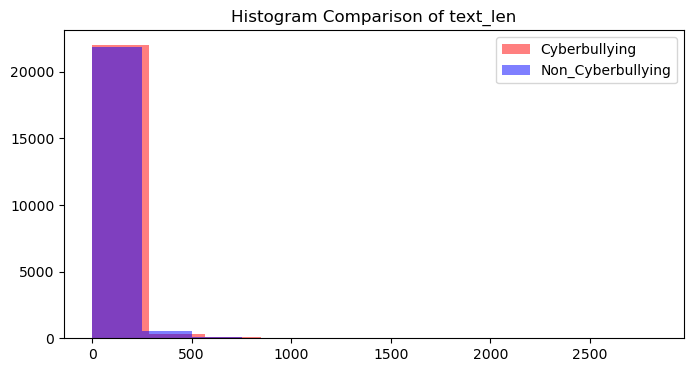

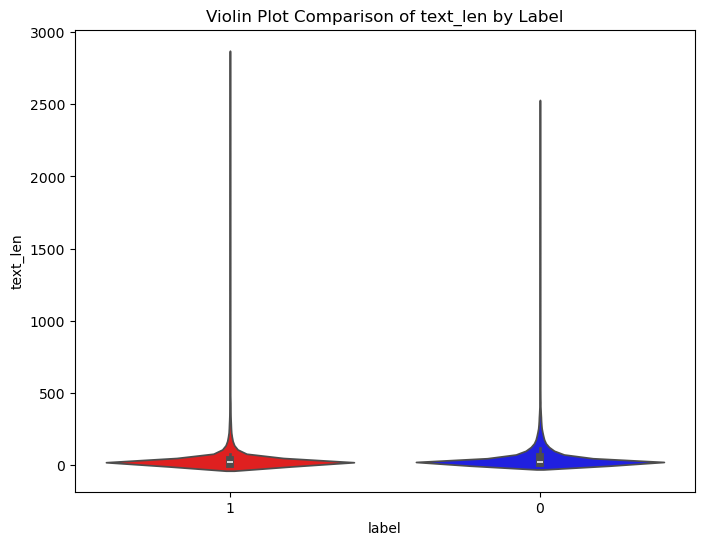

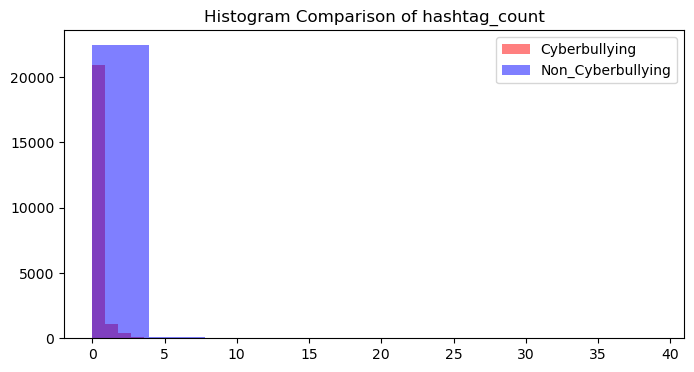

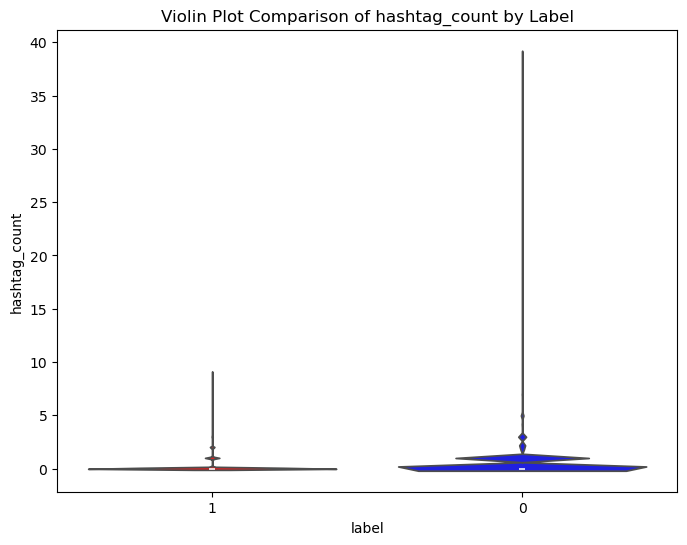

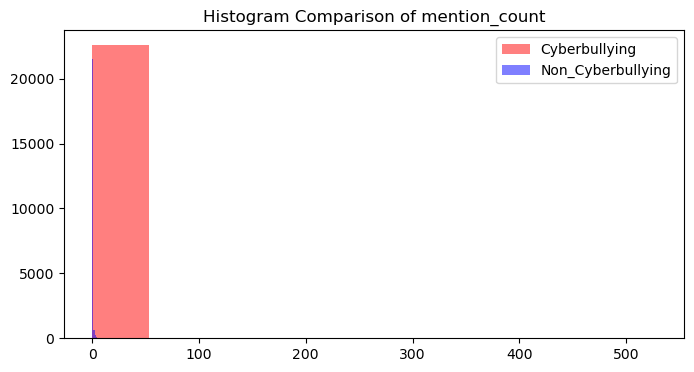

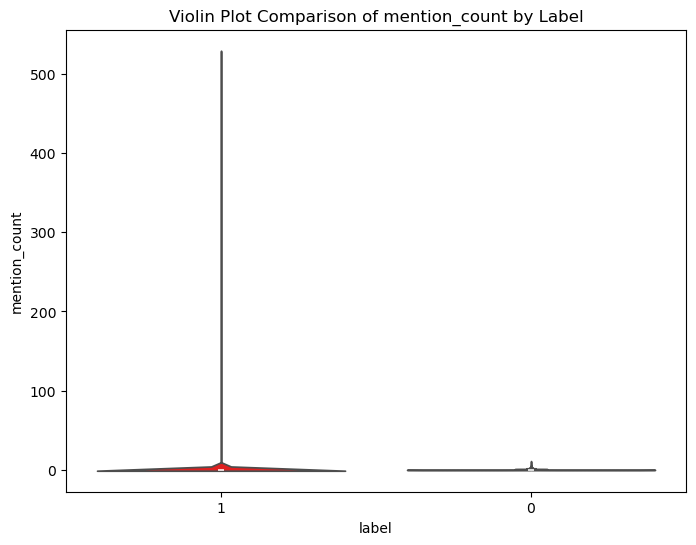

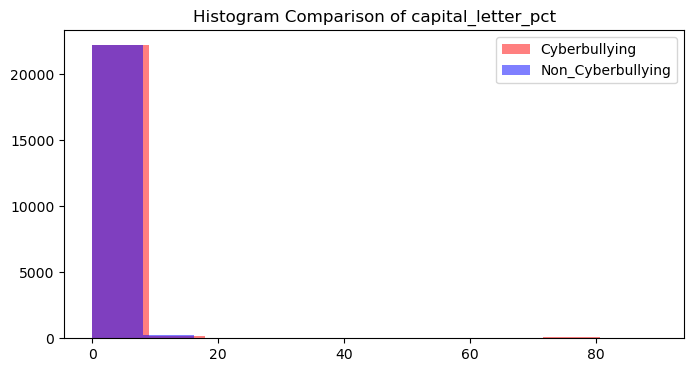

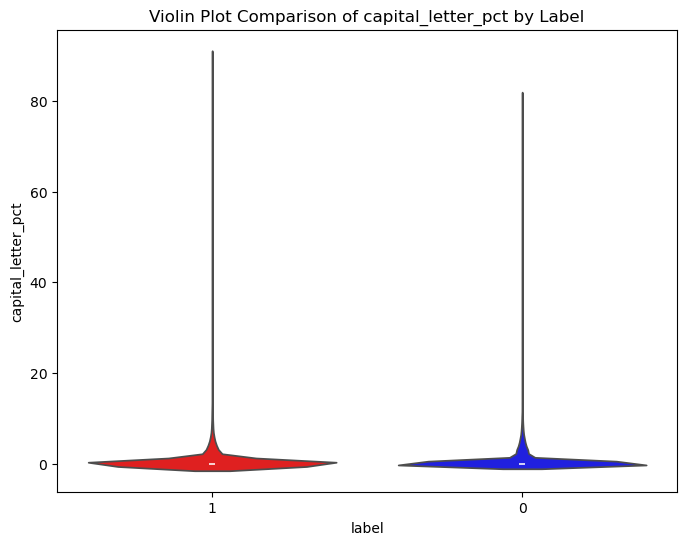

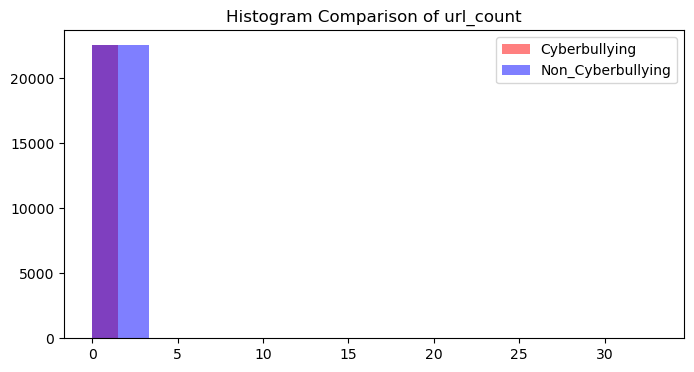

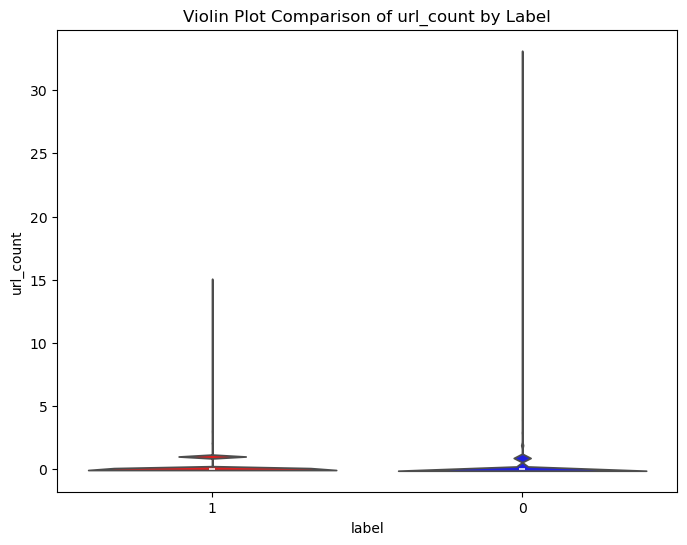

In [50]:
compare_cb_non_cb_statistics(result_df)

In [51]:
result_df.filename.unique()

array(['kaggle_data', 'wiki_data', 'twitter_data_relabel',
       'formspring_data', 'youtube_data'], dtype=object)

### Explore df through POS (Part-of-speech) Tagging
#### In this part, we just want to explore the structure of the text, focusing on sentiment analysis or named entity recognition, therefore, we did not apply preprocessing steps such as removing stopwords, applying lemmatization (or stemming)

In [52]:
nlp = spacy.load("en_core_web_sm")

In [53]:
cb_class = result_df[result_df['label'] == 1]
non_cb_class = result_df[result_df['label'] == 0]

In [54]:
print(cb_class.shape, non_cb_class.shape)

(22593, 9) (22593, 9)


In [56]:
%%time
cb_spacydocs = list(nlp.pipe(cb_class['text'], n_process = -1))
non_cb_spacydocs = list(nlp.pipe(non_cb_class['text'], n_process = -1))

CPU times: user 35.3 s, sys: 6.82 s, total: 42.1 s
Wall time: 59.5 s


In [61]:
# create df for cyberbullying and noncyberbullying tags
def create_tags_df(sapcydocs):
    tagsdf = []
    columns = ['token', 'ner_tag','pos_tag']
    
    def extract_token_tags(doc:spacy.tokens.doc.Doc):
        return [(i.text, i.ent_type_, i.pos_) for i in doc]

    for ix, doc in enumerate(sapcydocs):
        tags = extract_token_tags(doc)
        tags = pd.DataFrame(tags)
        tags.columns = columns
        tagsdf.append(tags)
    tagsdf=pd.concat(tagsdf)
    return tagsdf

In [62]:
%%time
#Create cyberbullying and non-cyberbullying tags df
cb_tagsdf = create_tags_df(cb_spacydocs)
non_cb_tagsdf = create_tags_df(non_cb_spacydocs)

CPU times: user 10.4 s, sys: 799 ms, total: 11.2 s
Wall time: 11.2 s


In [64]:
#total counts per unique token
pos_counts_cb = cb_tagsdf.groupby(['token','pos_tag']).size().reset_index(name = 'counts').sort_values(by='counts', ascending = False) 
pos_counts_non_cb = non_cb_tagsdf.groupby(['token','pos_tag']).size().reset_index(name = 'counts').sort_values(by='counts', ascending = False)

In [65]:
pos_counts_cb.head(10)

token pos_tag  counts
48        !   PUNCT   59217
63656   you    PRON   51940
380       .   PUNCT   48378
211       ,   PUNCT   33344
57481   the     DET   28648
34244     i    PRON   28500
10939     a     DET   28392
0             SPACE   25108
12602   and   CCONJ   20844
2041      ?   PUNCT   18719

In [66]:
pos_counts_non_cb.head(10)

token pos_tag  counts
423       .   PUNCT   56866
75278   the     DET   53851
211       ,   PUNCT   47871
13770     `   PUNCT   36826
0             SPACE   25725
16131   and   CCONJ   25450
43850     i    PRON   24917
57426    of     ADP   24905
13791     a     DET   23565
3600      :   PUNCT   21524

In [67]:
#top pos_tag cyberbullying
pos_counts_cb.groupby('pos_tag')['token'].count().sort_values(ascending = False).head() #pos-tag summarization

pos_tag
NOUN     23782
PROPN    15935
VERB     11018
ADJ       7022
ADV       2077
Name: token, dtype: int64

In [68]:
#top pos_tag non-cyberbullying
pos_counts_non_cb.groupby('pos_tag')['token'].count().sort_values(ascending = False).head(5)

pos_tag
NOUN     30556
PROPN    23598
VERB     12358
ADJ       9098
NUM       2910
Name: token, dtype: int64

It seems both cyberbullying and non-cyberbullying's top pos_tags are NOUN, Proper Noun and Verb. Next we will compare the top words per pos_tag in cyberbullying and non-cyberbullying by using word cloud visualization

In [69]:
pos_counts_cb[pos_counts_cb.pos_tag =='NOUN'][:20] #top noun token
# pos_counts_cb[pos_counts_cb.pos_tag =='PROPN'][:20] #top 'PROPN': specifically stands for "proper noun". Proper nouns are names for unique entities, such as "John", and they are typically capitalized in English.
# pos_counts_non_cb[pos_counts_non_cb.pos_tag =='NOUN'][:20]
# pos_counts_non_cb[pos_counts_non_cb.pos_tag =='PROPN'][:20] 
# pos_counts_cb[pos_counts_cb.pos_tag =='VERB'][:20]
# pos_counts_non_cb[pos_counts_non_cb.pos_tag =='VERB'][:20]

token pos_tag  counts
2006            =    NOUN   10560
28987        fuck    NOUN    5492
52842        shit    NOUN    4954
27117      faggot    NOUN    3096
45938      people    NOUN    2513
13599         ass    NOUN    2433
21560        cunt    NOUN    2430
45177        page    NOUN    2152
15838       bitch    NOUN    1607
62381   wikipedia    NOUN    1603
23216    dickhead    NOUN    1595
58020        time    NOUN    1419
38663        life    NOUN    1367
13442     article    NOUN    1358
19564        cock    NOUN    1312
46425       piece    NOUN    1280
63826  yourselfgo    NOUN    1245
60554   vandalism    NOUN    1139
56785        talk    NOUN    1027
13684     asshole    NOUN     970

In [91]:
def generate_worldcloud_vis_pos(tagsdf):
    tags = ['NOUN', 'PROPN', 'VERB']
    plt.figure(figsize=(16, 8))


    for index, tag in enumerate(tags):
        all_tokens = ' '.join(tagsdf[tagsdf['pos_tag'] == tag]['token'])

        # Create the word clouds
        wordcloud = WordCloud(background_color='white', collocations=False, random_state = random_state).generate(all_tokens);

        plt.subplot(1, 3, index + 1)  # 1 row, 3 columns, index+1 specifies position
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud _{tag}')

    plt.tight_layout()
    plt.show()

/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_c

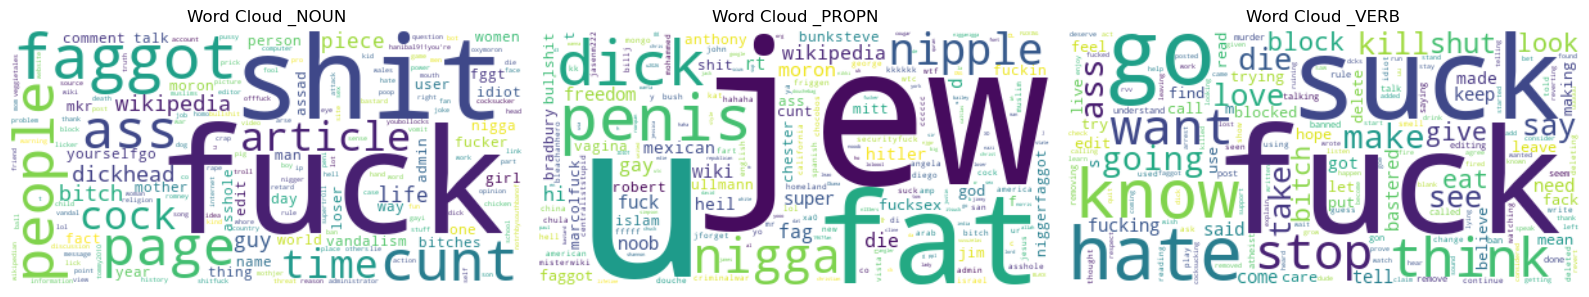

In [92]:
#word cloud for cyberbullying: Nouns, Proper Nouns and Verb
generate_worldcloud_vis_pos(cb_tagsdf)

/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_c

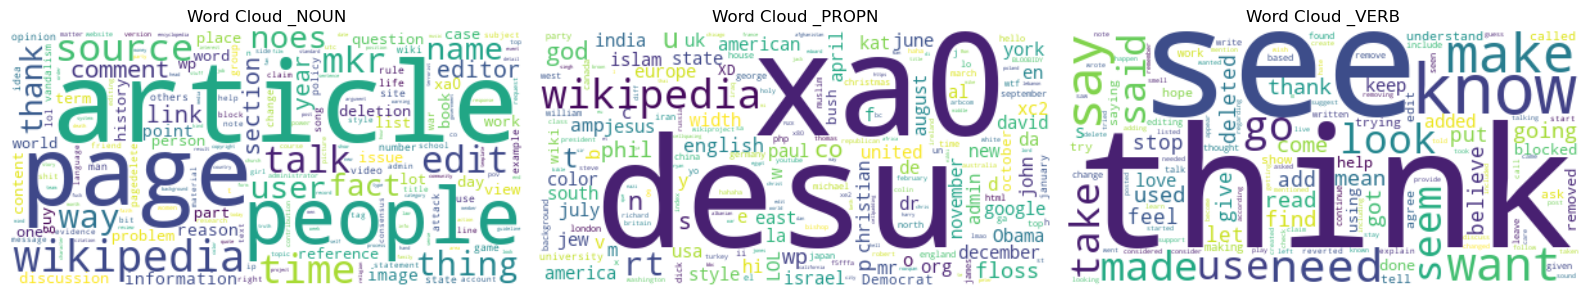

In [93]:
#word cloud for non cyberbullying: Nouns, Proper Nouns and Verb
generate_worldcloud_vis_pos(non_cb_tagsdf)

### extract named entities--> not much insignts

In [84]:
top_entities_cb = cb_tagsdf[cb_tagsdf['ner_tag'] !=''].groupby(['token','ner_tag']).size().reset_index(name ='counts').sort_values(by='counts', ascending = False) # ner_tag = Named Entity Recognition Tag

In [85]:
top_entities_non_cb = non_cb_tagsdf[non_cb_tagsdf['ner_tag'] !=''].groupby(['token','ner_tag']).size().reset_index(name ='counts').sort_values(by='counts', ascending = False)

[Text(0.5, 1.0, 'Most Common Named Entities in Cyberbullying')]

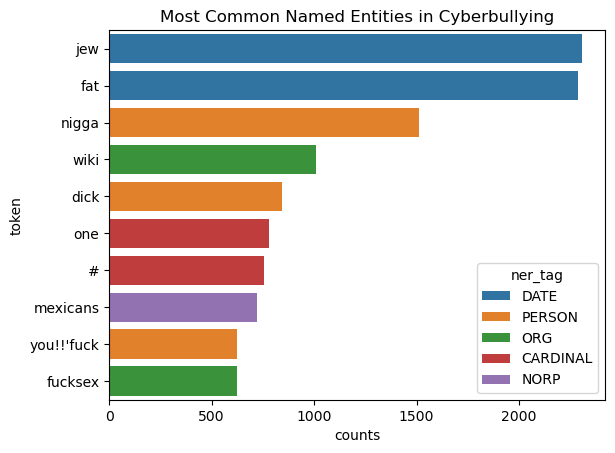

In [86]:
# plot Most Common Named Entities in Cyberbullying
sns.barplot(
    x= 'counts',
    y='token',
    hue='ner_tag',
    data = top_entities_cb[0:10],
    orient ='h',
    dodge = False

).set(title = 'Most Common Named Entities in Cyberbullying')

[Text(0.5, 1.0, 'Most Common Named Entities in Non-Cyberbullying')]

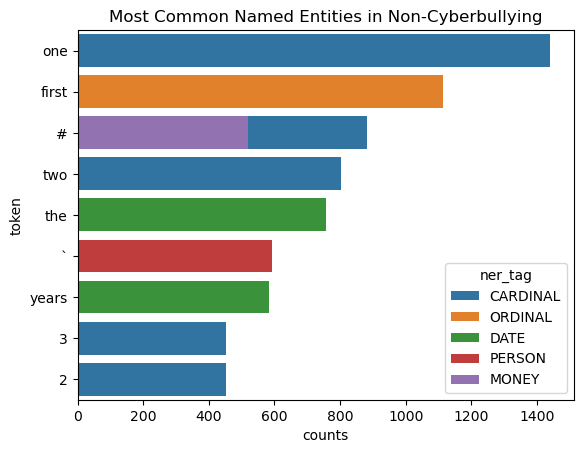

In [87]:
# plot Most Common Named Entities in Non Cyberbullying
sns.barplot(
    x= 'counts',
    y='token',
    hue='ner_tag',
    data = top_entities_non_cb[0:10],
    orient ='h',
    dodge = False

).set(title = 'Most Common Named Entities in Non-Cyberbullying')

## Sentimental Analysis

### Vader_sentiment

In [94]:
sid = SentimentIntensityAnalyzer()

In [95]:
def get_compound_score(x):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(x)['compound']

In [96]:
%%time
n_cores = -1
result_df['vader_sentiment_compound'] = Parallel(n_jobs=n_cores)(delayed(get_compound_score)(text) for text in result_df['text'])

CPU times: user 1.4 s, sys: 169 ms, total: 1.57 s
Wall time: 11.3 s


In [97]:
bins = [-1,-0.1,0.1,1] 
names =['negative','neutral','positive']

In [98]:
result_df['vader_sentiment_label']=pd.cut(result_df['vader_sentiment_compound'],bins, labels = names)

<Axes: xlabel='vader_sentiment_label'>

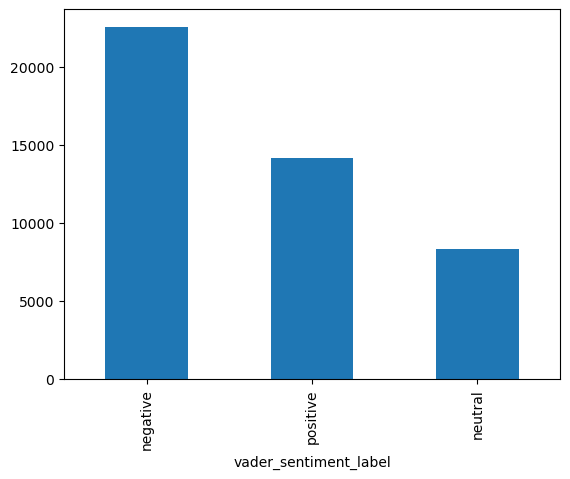

In [99]:
#distirbution of positive, negative and neatural
result_df['vader_sentiment_label'].value_counts().plot.bar()

[Text(0.5, 1.0, 'Sentiment by Label')]

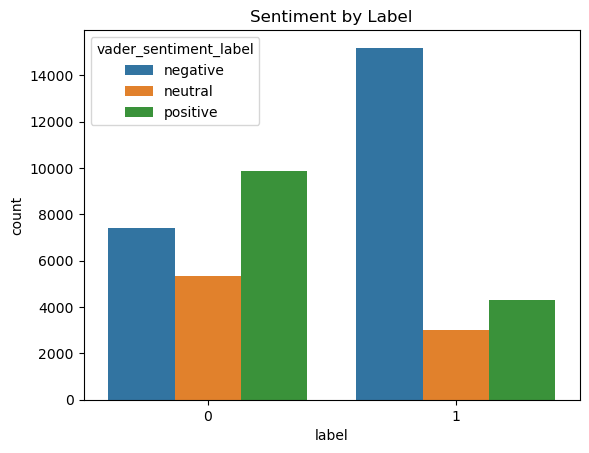

In [100]:
sns.countplot(
    x= 'label',
    hue = 'vader_sentiment_label',
    data = result_df
).set(title ='Sentiment by Label')

Cyberbullying text are more negative and less positive. Non-cyberbullying text are more positive and neutral. 

In [101]:
def plot_sentiment_by_label_per_filename(df):
    filenames = list(df['filename'].unique())
    
    # Determine the total number of files for the number of columns.
    n_files = len(filenames)
    
    fig, axes = plt.subplots(1, n_files, figsize=(5 * n_files, 5))
    
    for i, filename in enumerate(filenames):
        df_file = df[df['filename'] == filename]
        
        sns.countplot(
            x='label',
            hue='vader_sentiment_label',
            data=df_file,
            ax=axes[i]
        ).set(title=f'Sentiment by Label_{filename}')
    
    plt.tight_layout()
    plt.show()

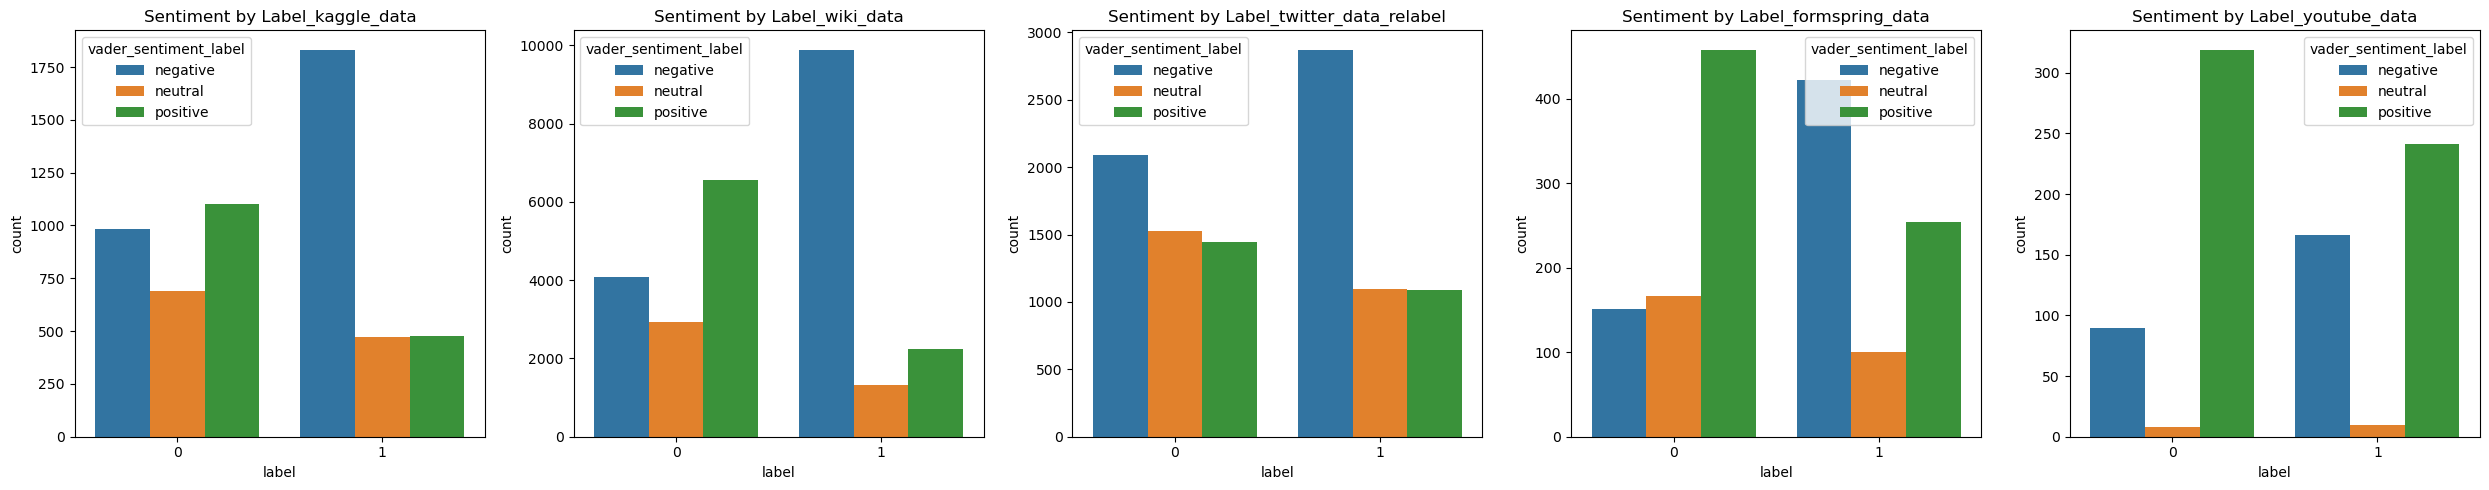

In [102]:
plot_sentiment_by_label_per_filename(result_df)

- Wiki, formspring: cyberbullying text are more negative, non-cyberbullying text more more positive 
- Kaggle: cyberbullying text are more negative.
- Twitter: both cyberbullying and non-cyberbullying text are more negative
- Youtube: both cyberbullying and non-cyberbullying text are more positive

## LDA model with bow

### clean and tokenize text

In [103]:
#need to modify the stopwords
CUSTOM_STOP_WORDS = ['www','tinyurl','com', 'https', 'http', '&amp', 'rt', 'bit', 'ly', 'bitly']
CUSTOM_STOP_WORDS_excl_wiki = ['wiki','wikipedia','articl','page','www','tinyurl','com', 'https', 'http','&amp', 'rt', 'bit', 'ly', 'bitly']

In [104]:
def clean_tokenize_text(df,stopwords):

    df['text'] = df['text'].astype(str)
    stop_words = STOPWORDS.union(set(stopwords))
    df['tokens'] = df['text'].apply(lambda x :preprocess_string(x) ) # preprocessing steps including stripe, remove stop_words, stem;this function is to provide token for topic modeling, therefore, gensim'function preprocess_string is prefered 
    
    def remove_sw(token): 
        return [word for word in token if not word in stop_words]
    
    df['tokens'] = df['tokens'].apply(lambda token:remove_sw(token))
    return df

In [105]:
%%time
df_tokens = clean_tokenize_text(result_df,CUSTOM_STOP_WORDS_excl_wiki)

CPU times: user 6.8 s, sys: 240 ms, total: 7.04 s
Wall time: 7.06 s


In [106]:
#add bigrams
def bigrams(df):

    tokens = df['tokens']
    phrases = Phrases(tokens, min_count = 20).freeze()
    df['bi_gram'] = df['tokens'].apply(lambda token:phrases[token])
    df['uni_gram'] = df['tokens']
    return df

In [107]:
df_bigrams = bigrams(df_tokens)

In [108]:
df_bigrams['filename'].unique()

array(['kaggle_data', 'wiki_data', 'twitter_data_relabel',
       'formspring_data', 'youtube_data'], dtype=object)

### Visualize tokens

In [110]:
def generate_worldcloud_vis(df_bigrams):
    tokens = [ 'uni_gram','bi_gram']
    # Separate the texts by label
    for token in tokens:

        no_cb_tokens = ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['label'] == 0][token]])
        cb_tokens= ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['label'] == 1][token]])

        # Create the word clouds
        wordcloud_no_cb = WordCloud(background_color='white',collocations=False,random_state = random_state).generate(no_cb_tokens)
        wordcloud_cb = WordCloud(background_color='white',collocations=False, random_state = random_state).generate(cb_tokens)

        plt.figure(figsize=(12, 4))

        # Word cloud for cb
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud_cb, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Cyberbullying_{token}' ) 

        # Word cloud for no_cb
        plt.subplot(1, 2, 2)
        plt.imshow(wordcloud_no_cb, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Non_Cyberbullying_{token}')

        plt.tight_layout()
        plt.show()

/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


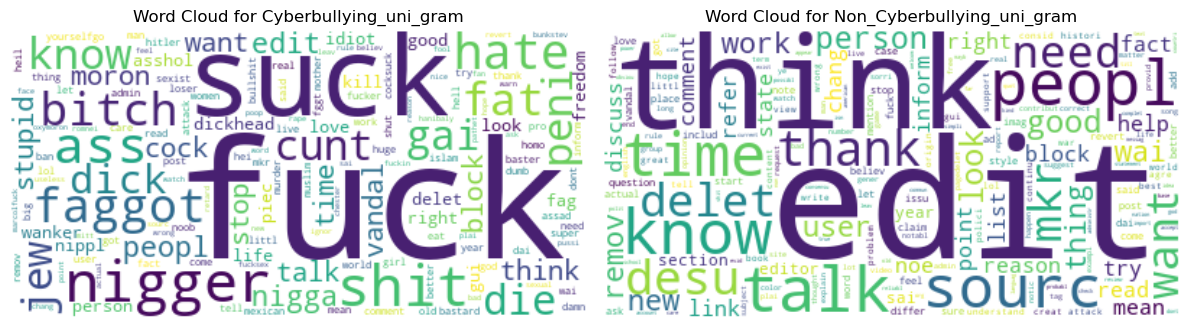

/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


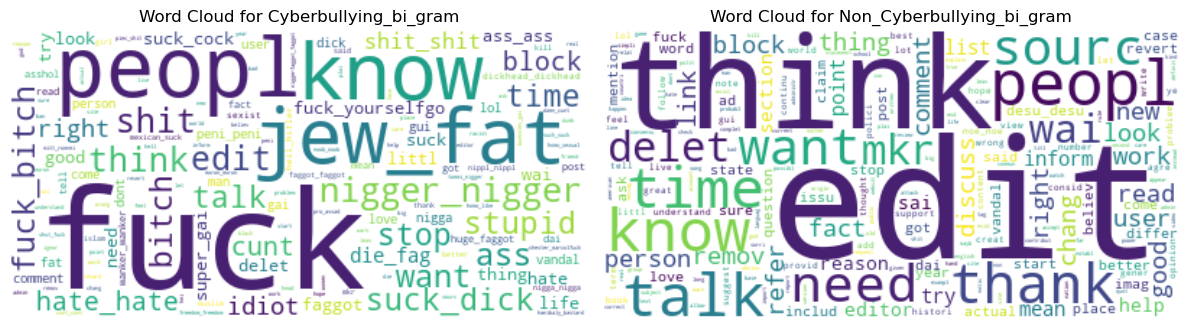

In [111]:
generate_worldcloud_vis(df_bigrams)

In [112]:
#all data
def generate_worldcloud_vis(df_bigrams):
    tokens = ['uni_gram', 'bi_gram']

    plt.figure(figsize=(12, 4))

    for index, token in enumerate(tokens, start=1):
        all_tokens = ' '.join([' '.join(tokens) for tokens in df_bigrams[token]])
        wordcloud = WordCloud(background_color='white', collocations=False).generate(all_tokens)

        plt.subplot(1, 2, index)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud _{token}')

    plt.tight_layout()
    plt.show()

/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/home/diludl/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


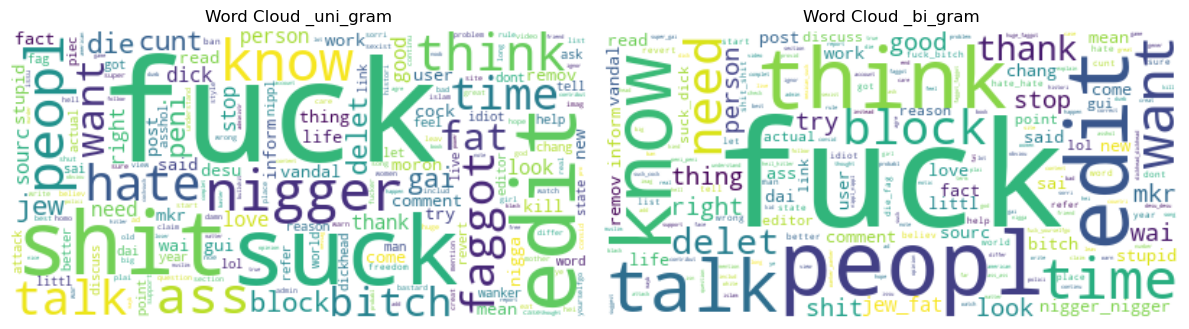

In [113]:
generate_worldcloud_vis(df_bigrams)

In [114]:
def generate_top_n_words_vis(df_bigrams, top_n, color):
    tokens = [ 'uni_gram','bi_gram']
    # Separate the texts by label
    #for token in tokens:
    for token in tokens:
        no_cb_tokens = ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['label'] == 0][token]])
        cb_tokens= ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['label'] == 1][token]])

        word_freq_no_cb = Counter(no_cb_tokens.split())
        most_common_no_cb = word_freq_no_cb.most_common(top_n)
        word_freq_no_cb = Counter(cb_tokens.split())
        most_common_cb = word_freq_no_cb.most_common(top_n)



        df2 = pd.DataFrame(most_common_no_cb, columns=['word', 'Non_Cyberbullyiing'])
        df1 = pd.DataFrame(most_common_cb, columns=['word', 'Cyberbullyiing'])

        # Merge the two dataframes on the word
        merged_df = pd.merge(df1, df2, on='word', how='outer').fillna(0)

        # Sort by one of the counts (optional)
        merged_df = merged_df.sort_values(by='Cyberbullyiing', ascending=False)

        # Create side by side bar charts
        ax = merged_df.plot.bar(x='word', y=['Cyberbullyiing', 'Non_Cyberbullyiing'], figsize=(28,8), color=color)

        # Set title and y-label
        ax.set_title(f'Comparison of Top {top_n} {token}')
        ax.set_ylabel('Count')
        #ax.set_xlabel('Words', fontsize=16)

        # Rotate x-axis labels for better visibility
        ax.set_xticklabels(merged_df['word'], rotation=45, ha='right',fontsize=18)

        plt.tight_layout()
        plt.show()

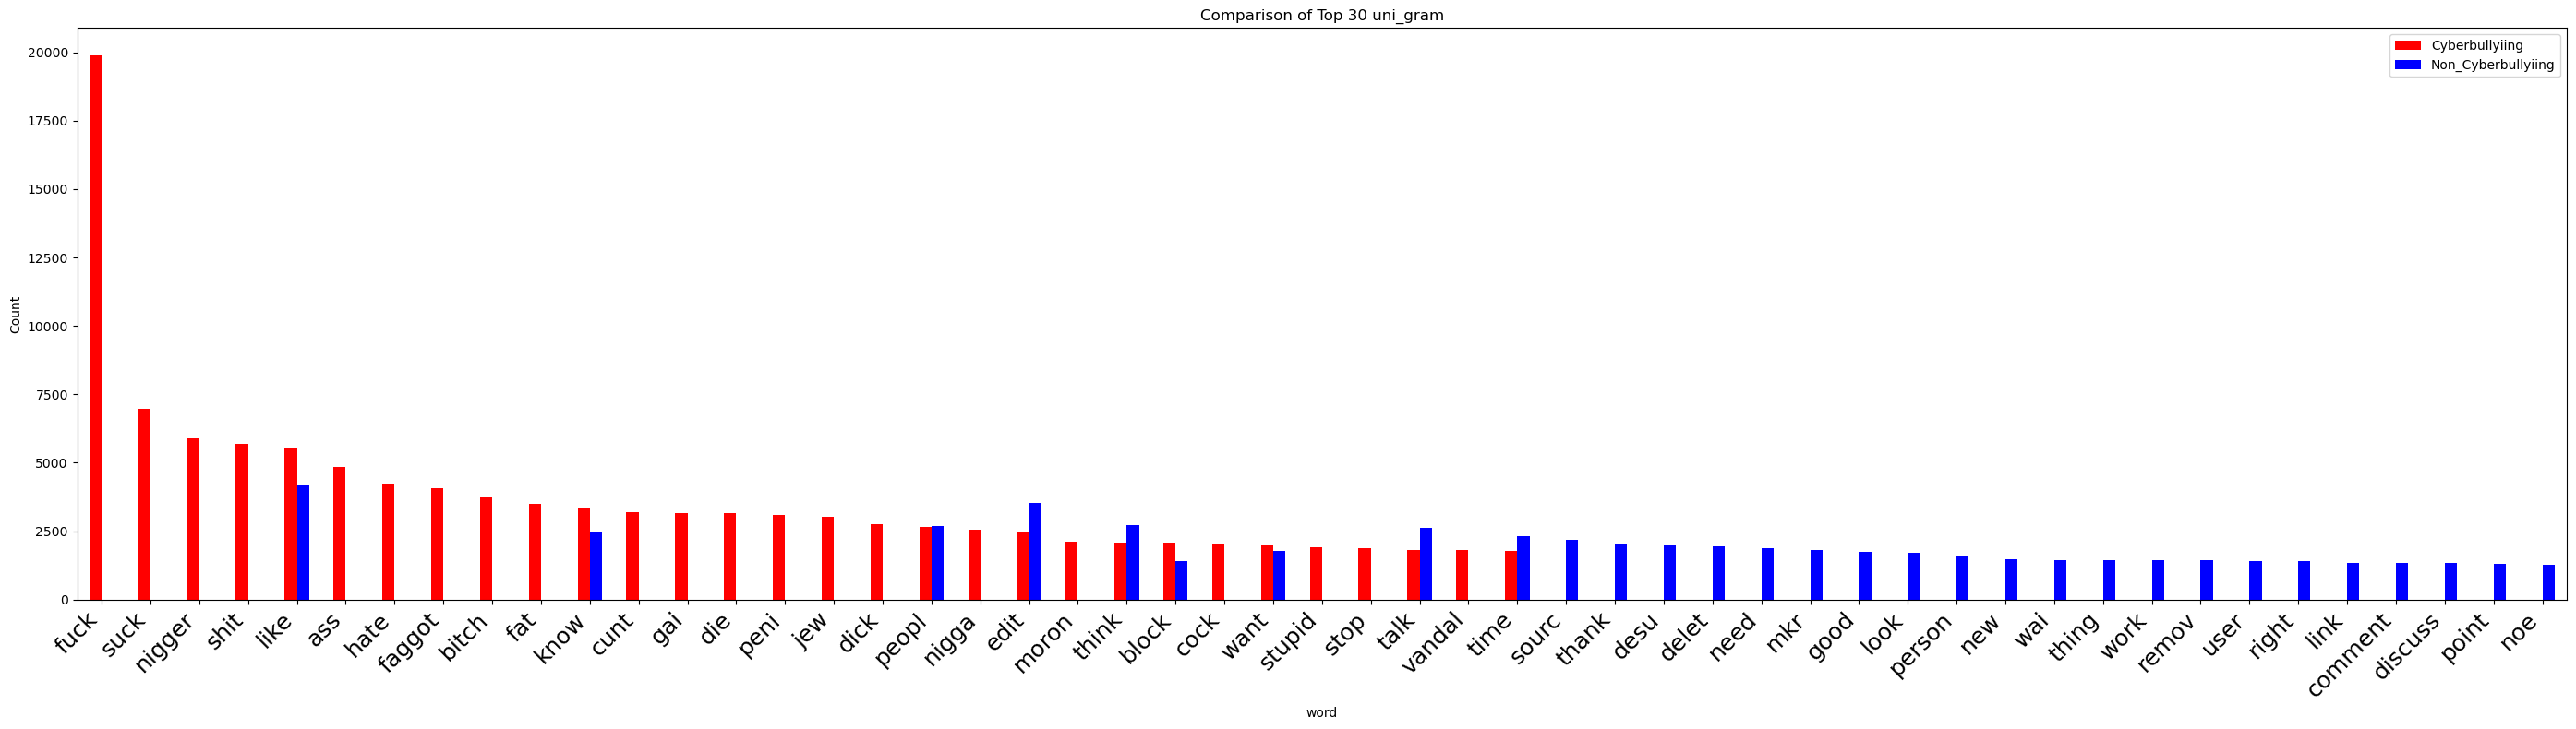

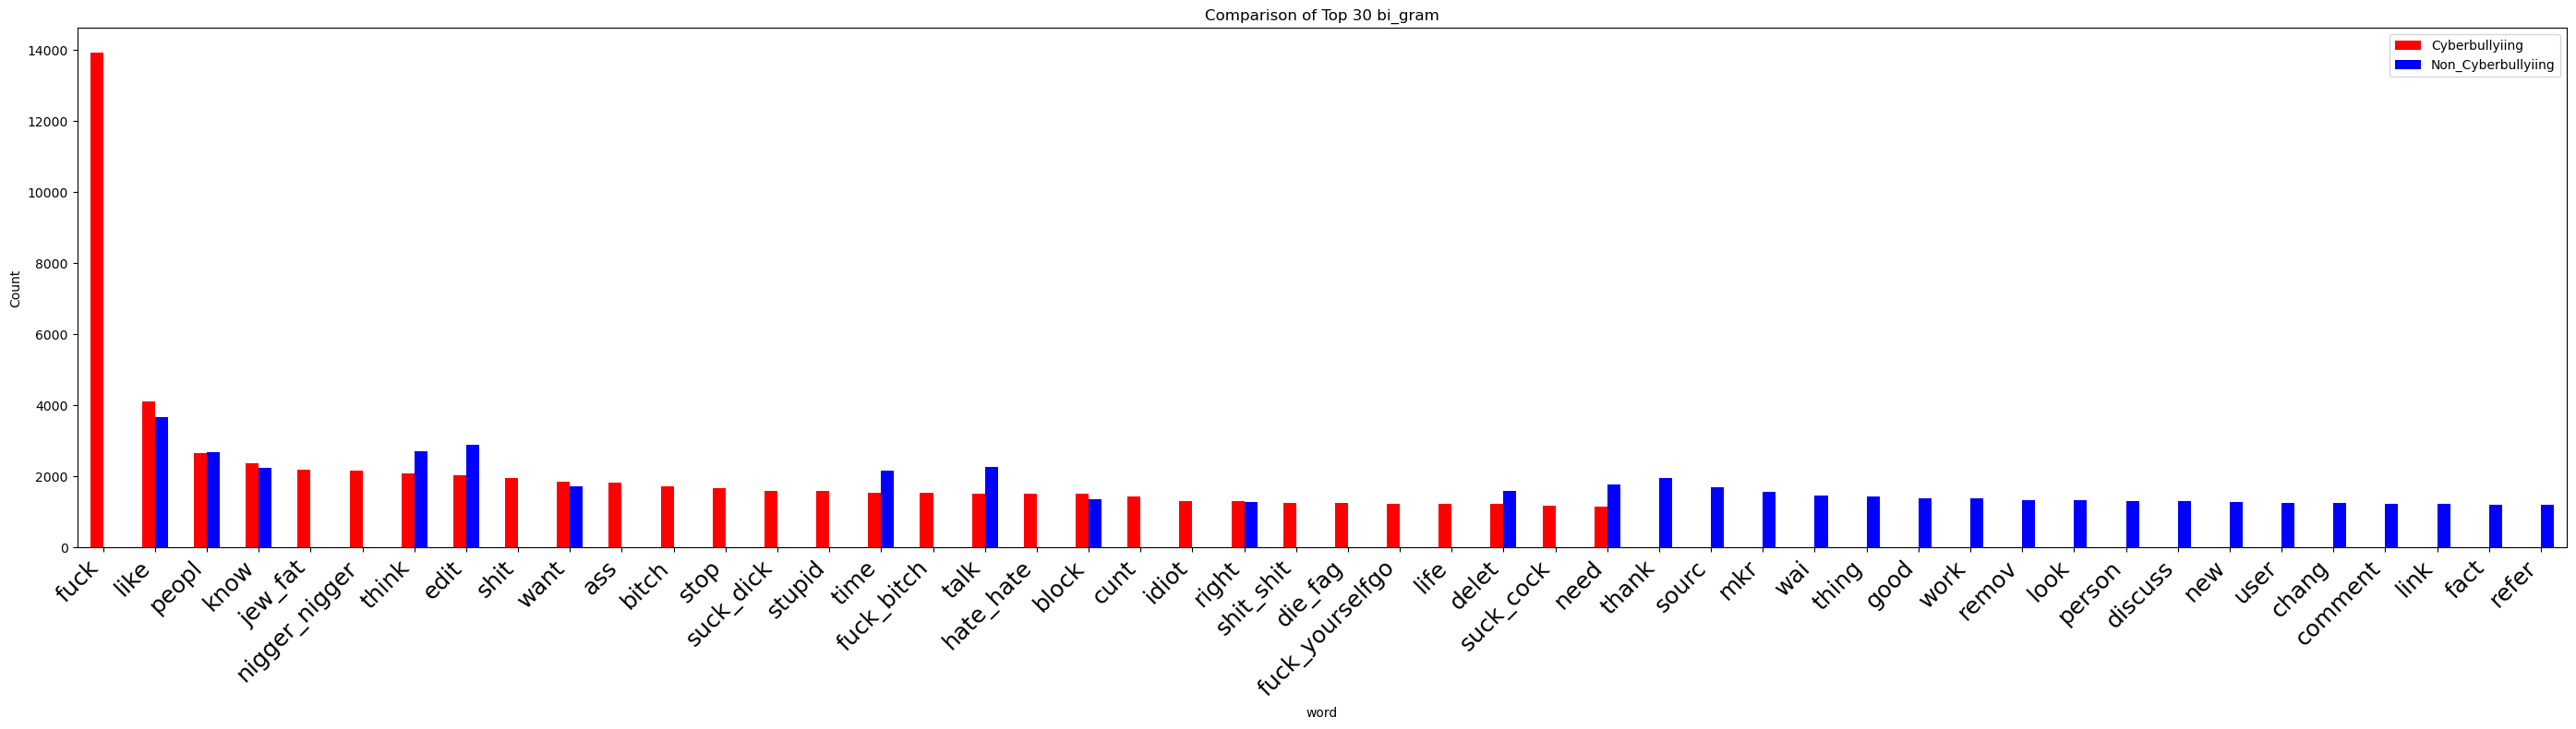

In [115]:
color= ['red','blue']
top_n = 30
generate_top_n_words_vis(df_bigrams, top_n, color)

## Topic Modeling with LDA

### Find number of topics

In [118]:
# !pip install --upgrade gensim

In [ ]:
def find_topics(tokens, num_topics):



    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=10, no_above=0.6, )

    corpus = [dictionary.doc2bow(text) for text in tokens]
    
    from gensim.models.ldamulticore import LdaMulticore# in case use multi-cores

    lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=random_state,
                         eta='auto', workers=None)  # Omitted alpha='auto'


    return lda_model.top_topics(corpus) 


In [120]:
df_bigrams['filename'].unique()

array(['kaggle_data', 'wiki_data', 'twitter_data_relabel',
       'formspring_data', 'youtube_data'], dtype=object)

In [121]:
df_bigrams.describe()

label      text_len  hashtag_count  mention_count  \
count  45186.000000  45186.000000   45186.000000   45186.000000   
mean       0.500000     52.773735       0.134887       0.297105   
std        0.500006    126.447219       0.620174       2.668935   
min        0.000000      1.000000       0.000000       0.000000   
25%        0.000000     12.000000       0.000000       0.000000   
50%        0.500000     22.000000       0.000000       0.000000   
75%        1.000000     46.000000       0.000000       0.000000   
max        1.000000   2832.000000      39.000000     528.000000   

       capital_letter_pct     url_count  vader_sentiment_compound  
count        45186.000000  45186.000000              45186.000000  
mean             0.852756      0.061125                 -0.137042  
std              5.111779      0.392560                  0.578560  
min              0.000000      0.000000                 -1.000000  
25%              0.000000      0.000000                 -0.659000  
50%              0.000000      0.000000                 -0.102700  
75%              0.000000      0.000000                  0.334225  
max             89.473684     33.000000                  1.000000

## Visualize coherence as the number of topics varies from 2 to 10

In [122]:
def calculate_avg_coherence(topics):

    avg_topic_coherence = sum([t[1] for t in topics]) / len(topics)
   
    return avg_topic_coherence

def plot_coherences_topics(tokens):

    topics_range = range(2, 11, 1)
    model_results = {'Topics': [],'Coherence': []}
    coherence = []
    for i in topics_range:
        topics = find_topics(tokens, num_topics=i)
        coherence.append(calculate_avg_coherence(topics))
    
    model_results['Topics'] = topics_range
    model_results['Coherence'] = coherence
    plt = pd.DataFrame(model_results).set_index('Topics').plot()

CPU times: user 3min 11s, sys: 1min 6s, total: 4min 18s
Wall time: 3min 55s


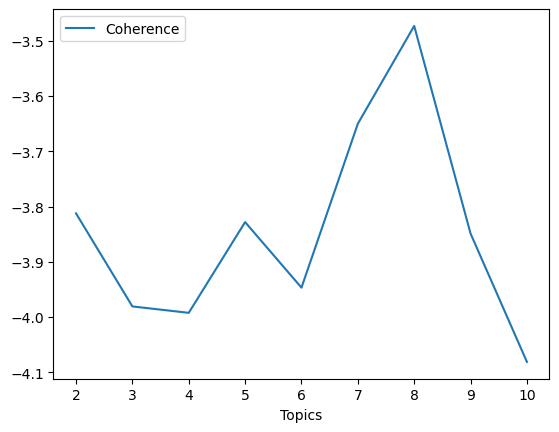

In [123]:
%%time
coherences_df = plot_coherences_topics(df_bigrams['bi_gram'])

In [124]:
def display_gensim_lda_topics(model, dictionary, no_top_words):
    for topic in range(model.num_topics):
        terms = model.get_topic_terms(topic, topn=no_top_words)
        total = sum([prob for _, prob in terms])
        print("\nTopic %02d" % topic)
        for word_id, prob in terms:
            word = dictionary[word_id]
            print("  %s (%2.2f%%)" % (word, prob*100.0/total))

In [125]:
%%time
dictionary = Dictionary(df_bigrams['bi_gram'])
dictionary.filter_extremes(no_below=10, no_above=0.6, )

corpus = [dictionary.doc2bow(text) for text in df_bigrams['bi_gram']]

# lda_model = LdaModel(corpus, num_topics=num_topics,id2word=dictionary,chunksize=2000,
#                      passes=20,iterations=400,eval_every=None,random_state=42,alpha='auto',eta='auto')


lda_model = LdaMulticore(corpus, num_topics=8, id2word=dictionary, chunksize=2000,
                     passes=20, iterations=400, eval_every=None, random_state=random_state,
                     eta='auto', workers=None)  # Omitted alpha='auto'

CPU times: user 29.5 s, sys: 7.36 s, total: 36.8 s
Wall time: 37 s


In [126]:
display_gensim_lda_topics(lda_model, dictionary,15 )


Topic 00
  peopl (11.65%)
  like (10.39%)
  kill (7.67%)
  time (7.59%)
  muslim (6.54%)
  right (6.34%)
  year (6.25%)
  women (6.07%)
  wai (6.00%)
  know (5.79%)
  think (5.53%)
  need (5.51%)
  jew (5.13%)
  live (4.89%)
  thing (4.64%)

Topic 01
  islam (11.84%)
  faggot (11.81%)
  like (9.28%)
  gai (9.07%)
  mitt_romnei (8.84%)
  edit (8.40%)
  time (5.26%)
  muslim (4.77%)
  know (4.76%)
  idiot (4.66%)
  god (4.62%)
  peopl (4.58%)
  murder (4.17%)
  school (4.10%)
  religion (3.81%)

Topic 02
  suck_cock (14.95%)
  mkr (13.58%)
  edit (10.98%)
  know (6.97%)
  stop (6.93%)
  talk (6.69%)
  dick (6.58%)
  suck (5.95%)
  stupid (4.14%)
  want (4.03%)
  new (3.94%)
  peopl (3.92%)
  help (3.88%)
  right (3.85%)
  think (3.61%)

Topic 03
  fuck_bitch (19.64%)
  shit_shit (16.36%)
  fact (7.23%)
  peopl (5.99%)
  want (5.67%)
  state (5.60%)
  english (5.46%)
  sourc (5.37%)
  think (4.41%)
  languag (4.26%)
  term (4.24%)
  nation (4.18%)
  refer (3.93%)
  includ (3.83%)
  time 

In [127]:
#find_topics(df_bigrams['bi_gram'].dropna(), num_topics=4)

## Plot top topics

In [128]:
def plot_topics(df, num_topics, num_words,token):
    """ 

    """
    def create_top_topics(df):
        bigrams_token_feature=df.loc[:,[token]]
        tokens = bigrams_token_feature[token]
        dictionary = Dictionary(tokens)
        dictionary.filter_extremes(no_below=10, no_above=0.6, )
        corpus = [dictionary.doc2bow(text) for text in tokens]

        lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=42,
                         eta='auto', workers=None)  # Omitted alpha='auto'

        top_topics = lda_model.top_topics(corpus)
        return top_topics

    def create_heatmap(top_topics):
        avg_coherences = [f'Topic {idx+1}\n({round(i[1],2)})' for idx, i in enumerate(top_topics)]
        result_lst = []
        annot_lst = []
        for idx, row in enumerate(top_topics):
            result_lst.append([])
            annot_lst.append([])
            for j, k in row[0][:num_words]:
                result_lst[idx].append(round(j,2))
                annot_lst[idx].append(f'''{k}\n{str(round(j,2))}''')

        plt.figure(figsize=(25,7)) 
        plt.title('bigram')
        sns.heatmap(pd.DataFrame(result_lst),annot=pd.DataFrame(annot_lst),fmt='',cmap='YlGnBu',
                   xticklabels = False, yticklabels = avg_coherences)

    
    top_topics = create_top_topics(df)
    create_heatmap(top_topics)
    

CPU times: user 24.1 s, sys: 8.01 s, total: 32.1 s
Wall time: 30.6 s


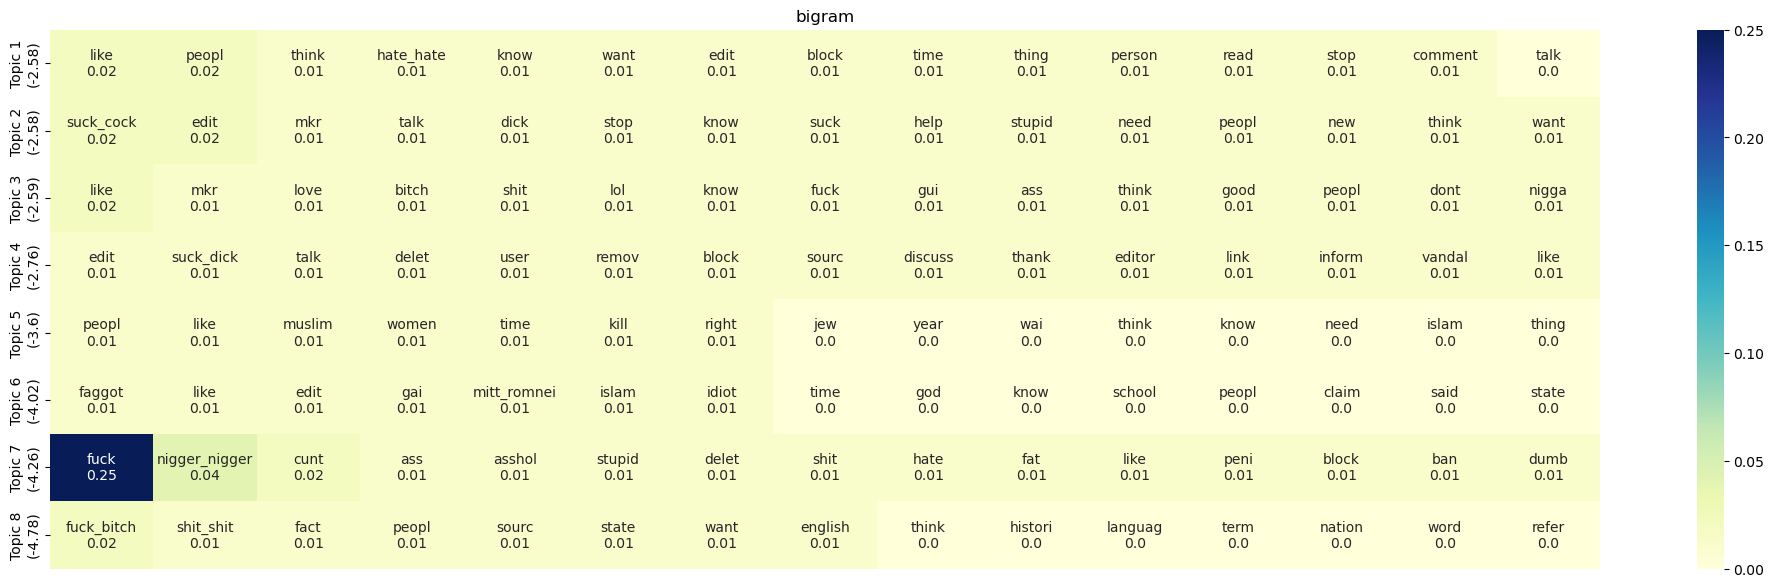

In [129]:
%%time
num_topics= 8
token = 'bi_gram'
plot_topics(df_bigrams, num_topics,15 ,token)

### use pyLDAvis to visualize the topic

In [130]:
%%time
dictionary = Dictionary(df_bigrams['bi_gram'])
dictionary.filter_extremes(no_below=10, no_above=0.6, )

corpus = [dictionary.doc2bow(text) for text in df_bigrams['bi_gram']]

lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, chunksize=2000,
                     passes=20, iterations=400, eval_every=None, random_state=random_state,
                     eta='auto', workers=None)  # Omitted alpha='auto'


CPU times: user 23.1 s, sys: 6.52 s, total: 29.6 s
Wall time: 29.7 s


In [131]:
%%time
pyLDAvis.enable_notebook()

vis_data = gensimvis.prepare(lda_model, corpus, dictionary, n_jobs=-1)
pyLDAvis.display(vis_data) 


CPU times: user 8.86 s, sys: 43.5 ms, total: 8.9 s
Wall time: 8.93 s


Reference: https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis/#:~:text=Relevance%20is%20denoted%20by%20%CE%BB,ranked%20only%20by%20their%20lift.
The user can adjust λ in the pyLDAvis interface to change the ranking of terms:

A high λ (close to 1) will rank terms purely based on their probability within a topic. This might highlight terms that are frequent in a topic but may also be frequent across other topics.

A lower λ will prioritize terms that are distinct to that topic compared to others. This often surfaces terms that are more unique and defining for a topic, even if they are not the most frequent terms in the topic.

Using the slider in the visualization to adjust λ can give you different perspectives on what characterizes a topic: from its most frequent terms to its most unique ones. Adjusting and examining the term list at different λ values can help in better understanding and interpreting the topics generated by the model.

## group topics by features

In [132]:

def plot_coherences_topics_by_features(df, feature, token):

    def calculate_avg_coherence(topics):

        avg_topic_coherence = sum([t[1] for t in topics]) / len(topics)

        return avg_topic_coherence

    def plot_coherences_topics(tokens):

        topics_range = range(2, 11, 1)
        model_results = {'Topics': [],'Coherence': []}
        coherence = []
        for i in topics_range:
            topics = find_topics(tokens, num_topics=i)
            coherence.append(calculate_avg_coherence(topics))

        model_results['Topics'] = topics_range
        model_results['Coherence'] = coherence
        plt = pd.DataFrame(model_results).set_index('Topics').plot()
        
    feature_values = sorted(df[feature].unique())
    for feature_value in feature_values:
        bigrams_token_feature=df.loc[df[feature]==feature_value,[token]]
        plot_coherences_topics(bigrams_token_feature[token])
        

CPU times: user 9min 38s, sys: 2min 2s, total: 11min 41s
Wall time: 14min 44s


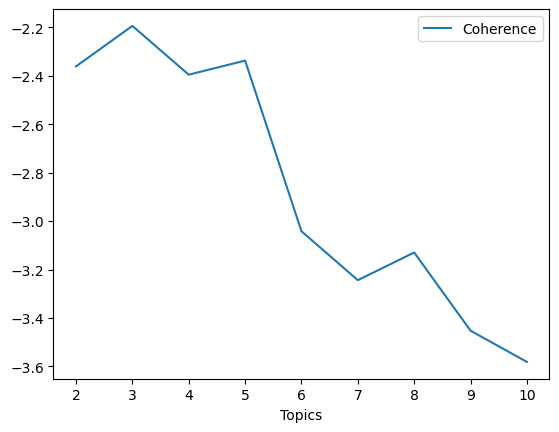

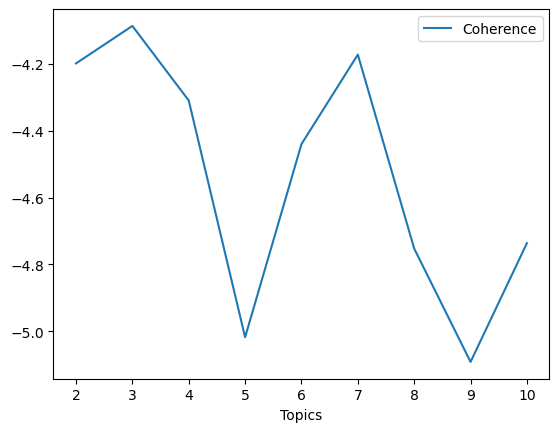

In [133]:
%%time
plot_coherences_topics_by_features(df_bigrams,'label','bi_gram')

In [ ]:
print("the best topic number for label = 0 is 3")
print('the best topic number for label = 1 is 3')

In [ ]:
sorted(df_bigrams['filename'].unique())

In [ ]:
%%time
plot_coherences_topics_by_features(df_bigrams,'filename','bi_gram')

In [ ]:

print("the best topic number for file 1 formspring_data is 2 ")
print('the best topic number for file 2 kaggle_data is 2')
print('the best topic number for file 3 twitter is 2')
print('the best topic number for file 4 wiki is 4')
print('the best topic number for file 5 youtube is 2')

In [ ]:
def plot_topics_per_feature_value(df, num_topics, num_words,feature,token):
    """ 

    """
    def create_top_topics(df,num_topic, feature, feature_value):
        bigrams_token_feature=df.loc[df[feature]==feature_value,[token]]
        #num_topics = 6
        tokens = bigrams_token_feature[token]
        dictionary = Dictionary(tokens)
        dictionary.filter_extremes(no_below=10, no_above=0.6, )
        corpus = [dictionary.doc2bow(text) for text in tokens]

        lda_model = LdaMulticore(corpus, num_topics=num_topic, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=42,
                         eta='auto', workers=None)  # Omitted alpha='auto'

        top_topics = lda_model.top_topics(corpus)
        return top_topics

    def create_heatmap(top_topics,feature_value):
        avg_coherences = [f'Topic {idx+1}\n({round(i[1],2)})' for idx, i in enumerate(top_topics)]
        result_lst = []
        annot_lst = []
        for idx, row in enumerate(top_topics):
            result_lst.append([])
            annot_lst.append([])
            for j, k in row[0][:num_words]:
                result_lst[idx].append(round(j,2))
                annot_lst[idx].append(f'''{k}\n{str(round(j,2))}''')

        plt.figure(figsize=(25,7)) 
        plt.title(feature_value)
        sns.heatmap(pd.DataFrame(result_lst),annot=pd.DataFrame(annot_lst),fmt='',cmap='YlGnBu',
                   xticklabels = False, yticklabels = avg_coherences)

    feature_values = sorted(df[feature].unique())
    for feature_value, num_topic in zip(feature_values,num_topics):
        top_topics = create_top_topics(df,num_topic ,feature, feature_value)
        create_heatmap(top_topics,feature_value)
   
 
    


In [ ]:
num_topics = [3,2]
feature = 'label'
token = 'bi_gram'

plot_topics_per_feature_value(df_bigrams, num_topics, 15,feature, token)

In [ ]:
num_topics = [2,2,2,4,2]
feature = 'filename'
token ='bi_gram'
plot_topics_per_feature_value(df_bigrams, num_topics, 15,feature, token)

## NMF with TFIDF

In [221]:
result_df.head(2)

text  \
145186                                                               "Let BaseGod fuck your bith man...Let him purge you of that Hate."   
145189  "bitch fuck A e-thug,MOTHER FUCKER im A cold hearted SHAOLIN MONK,and believe me when i tell you THIS,I WILL HUNT YOU DOWN !!!"   

        label     filename split  text_len  hashtag_count  mention_count  \
145186      1  kaggle_data   NaN        12              0              0   
145189      1  kaggle_data   NaN        23              0              0   

        capital_letter_pct  url_count  vader_sentiment_compound  \
145186            7.575758          0                    -0.802   
145189           35.433071          0                    -0.935   

       vader_sentiment_label  \
145186              negative   
145189              negative   

                                                                                     tokens  \
145186                                     [let, basegod, fuck, bith, man, let, purg, hate]   
145189  [bitch, fuck, thug, mother, fucker, cold, heart, shaolin, monk, believ, tell, hunt]   

                                                                                  bi_gram  \
145186                                   [let, basegod, fuck, bith, man, let, purg, hate]   
145189  [bitch_fuck, thug, mother_fucker, cold, heart, shaolin, monk, believ, tell, hunt]   

                                                                                   uni_gram  
145186                                     [let, basegod, fuck, bith, man, let, purg, hate]  
145189  [bitch, fuck, thug, mother, fucker, cold, heart, shaolin, monk, believ, tell, hunt]

## Text Preprocessing

TfidfVectorizer will tokenzie the text, lowercase the token, remove punctuatio, symbosa and numbers including =

steps:
- remove emoji (https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1)
- remove URL
- remove mentions like '@username'
- remove #
- remove custom stopwords
- lemmatization

In [222]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"  # Enclosed characters
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_text(text):
    text = remove_emojis(text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w*', '', text) 
    text = re.sub(r'#', '', text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in text.split()]
    return " ".join(tokens)

In [223]:
%%time
result_df['processed_text'] = result_df['text'].apply(preprocess_text)

CPU times: user 6.97 s, sys: 117 ms, total: 7.08 s
Wall time: 7.11 s


In [224]:
result_df.head(2)

text  \
145186                                                               "Let BaseGod fuck your bith man...Let him purge you of that Hate."   
145189  "bitch fuck A e-thug,MOTHER FUCKER im A cold hearted SHAOLIN MONK,and believe me when i tell you THIS,I WILL HUNT YOU DOWN !!!"   

        label     filename split  text_len  hashtag_count  mention_count  \
145186      1  kaggle_data   NaN        12              0              0   
145189      1  kaggle_data   NaN        23              0              0   

        capital_letter_pct  url_count  vader_sentiment_compound  \
145186            7.575758          0                    -0.802   
145189           35.433071          0                    -0.935   

       vader_sentiment_label  \
145186              negative   
145189              negative   

                                                                                     tokens  \
145186                                     [let, basegod, fuck, bith, man, let, purg, hate]   
145189  [bitch, fuck, thug, mother, fucker, cold, heart, shaolin, monk, believ, tell, hunt]   

                                                                                  bi_gram  \
145186                                   [let, basegod, fuck, bith, man, let, purg, hate]   
145189  [bitch_fuck, thug, mother_fucker, cold, heart, shaolin, monk, believ, tell, hunt]   

                                                                                   uni_gram  \
145186                                     [let, basegod, fuck, bith, man, let, purg, hate]   
145189  [bitch, fuck, thug, mother, fucker, cold, heart, shaolin, monk, believ, tell, hunt]   

                                                                                                                         processed_text  
145186                                                               "Let BaseGod fuck your bith man...Let him purge you of that Hate."  
145189  "bitch fuck A e-thug,MOTHER FUCKER im A cold hearted SHAOLIN MONK,and believe me when i tell you THIS,I WILL HUNT YOU DOWN !!!"

In [225]:
#need to modify the stopwords
CUSTOM_STOP_WORDS = ['www','tinyurl','com', 'https', 'http', 'rt', 'bit', 'ly', 'bitly', 'wiki','wikipedia','article','page','amp']
tfidf_stopwords = set(ENGLISH_STOP_WORDS)
combined_stopwords = list(tfidf_stopwords.union(CUSTOM_STOP_WORDS))

In [226]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words=combined_stopwords, max_df=0.85, min_df=5, max_features=5000)
tfidf_vectorizer = vectorizer.fit_transform(result_df['processed_text'])
tfidf_vectorizer_feature_names =vectorizer.get_feature_names_out()

In [227]:
tfidf_vectorizer.shape

(45186, 5000)

In [228]:
n_topics = 8
nmf = NMF(n_components=n_topics, random_state=random_state, init = 'nndsvd').fit(tfidf_vectorizer)


In [229]:
W_text_matrix = nmf.fit_transform(tfidf_vectorizer)
H_text_matrix = nmf.components_

In [230]:
# Display topics; the numbers are the percentage contributions of the words to the respective topic
def display_sklean_nmf_topics(model, feature_names, no_top_words):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f%%)" %  (feature_names[largest[i]],
                  word_vector[largest[i]]*100.0/total))

# def display_topics(model, feature_names, no_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         print(f"Topic {topic_idx + 1}:")
#         print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_sklean_nmf_topics(nmf, vectorizer.get_feature_names_out(), 15) #the percentages of the words within a topic are a good indication for the quality of the topic model. If the percentage within a topic is rapidly decreasing, the topic is well-defined, whereas slowly decreasing word probabilities indicate a less-pronounced topic. It’s much more difficult to intuitively find out how well the topics are separated; we will take a look at that later.


Topic 00
  like (1.35%)
  just (1.01%)
  don (0.94%)
  know (0.88%)
  people (0.75%)
  think (0.67%)
  ha (0.57%)
  talk (0.52%)
  want (0.47%)
  make (0.46%)
  time (0.43%)
  good (0.43%)
  really (0.42%)
  say (0.41%)
  look (0.40%)

Topic 01
  fuck (39.17%)
  bitch (1.76%)
  asshole (1.64%)
  shut (1.48%)
  shit (1.31%)
  cunt (0.91%)
  faggot (0.76%)
  want (0.73%)
  ass (0.69%)
  fuckin (0.57%)
  hey (0.53%)
  mother (0.52%)
  nigger (0.52%)
  leave (0.48%)
  nigga (0.46%)

Topic 02
  mkr (20.90%)
  kat (6.96%)
  andre (3.05%)
  mkr2015 (1.58%)
  girl (1.12%)
  colin (0.97%)
  annie (0.82%)
  cook (0.82%)
  nikki (0.76%)
  katie (0.71%)
  oh (0.70%)
  blonde (0.69%)
  cooking (0.67%)
  ca (0.65%)
  look (0.62%)

Topic 03
  fucking (14.54%)
  shit (5.84%)
  bitch (4.37%)
  cunt (2.06%)
  piece (1.80%)
  faggot (1.66%)
  stupid (1.47%)
  asshole (1.17%)
  stop (1.08%)
  life (1.04%)
  mother (0.84%)
  gay (0.77%)
  hell (0.75%)
  die (0.65%)
  little (0.61%)

Topic 04
  sexist (11.

In [231]:
#find out how “big” the topics are, i.e., how many documents could be assigned mainly to each topic. 
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0 #Having an even distribution is a quality indicator. If your topic models have, for example, one or two large topics compared to all the others, you should probably adjust the number of topics.

array([27.56476351, 12.67092373, 11.12100485, 12.09115094,  9.9416801 ,
        7.30442833, 12.79192856,  6.51411998])

### gensim NMF 
sklean NMF can use tfidf weights, however, it does not include coherence score. We will use the gensim's NMF to find the best number of topics 

In [232]:
result_df_nmf = result_df.copy()

In [233]:
def clean_tokenize_text(df,stopwords):

    df['processed_text'] = df['processed_text'].astype(str)
    stop_words = STOPWORDS.union(set(stopwords))
    df['tokens'] = df['processed_text'].apply(lambda x :preprocess_string(x) ) # preprocessing steps including stripe, remove stop_words, stem;this function is to provide token for topic modeling, therefore, gensim'function preprocess_string is prefered 
    
    def remove_sw(token): 
        return [word for word in token if not word in stop_words]
    
    df['tokens'] = df['tokens'].apply(lambda token:remove_sw(token))
    return df

In [234]:
%%time
result_df_nmf_tokens = clean_tokenize_text(result_df_nmf,CUSTOM_STOP_WORDS_excl_wiki)

CPU times: user 6.35 s, sys: 15.6 ms, total: 6.36 s
Wall time: 6.38 s


In [235]:
#add bigrams
def bigrams(df):

    tokens = df['tokens']
    phrases = Phrases(tokens, min_count = 20).freeze()
    df['bi_gram'] = df['tokens'].apply(lambda token:phrases[token])
    df['uni_gram'] = df['tokens']
    return df

In [236]:
df_nmf_bigrams = bigrams(result_df_nmf_tokens)

In [237]:
df_nmf_bigrams['filename'].unique()

array(['kaggle_data', 'wiki_data', 'twitter_data_relabel',
       'formspring_data', 'youtube_data'], dtype=object)

In [238]:
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from multiprocessing import Pool, cpu_count

In [239]:
#sklean NMF can use tfidf weights, however, it does not include coherence score. We will use the gensim's NMF to find the best number of topics 

In [240]:
import warnings

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Creating a dictionary and corpus
dictionary = Dictionary(df_nmf_bigrams['bi_gram'])
dictionary.filter_extremes(no_below=10, no_above=0.6)
corpus = [dictionary.doc2bow(text) for text in df_nmf_bigrams['bi_gram']]

In [241]:
%%time
coherence_scores = []
for num in list(range(2, 11, 1)):
    nmf_model = Nmf(corpus,
                num_topics=num,
                id2word=dictionary,
                chunksize=2000,
                passes=20,
                kappa=.1,
                minimum_probability=0.01,
                w_max_iter=300,
                w_stop_condition=0.0001,
                h_max_iter=100,
                h_stop_condition=0.001,
                eval_every=10,
                normalize=True,
                random_state=42)
    cm = CoherenceModel(
                    model=nmf_model,
                    texts=df_nmf_bigrams['bi_gram'],
                    dictionary=dictionary,
                    coherence='c_v')
    coherence_scores.append(round(cm.get_coherence(), 4))

CPU times: user 11min 44s, sys: 1h 8min 33s, total: 1h 20min 17s
Wall time: 3min 21s


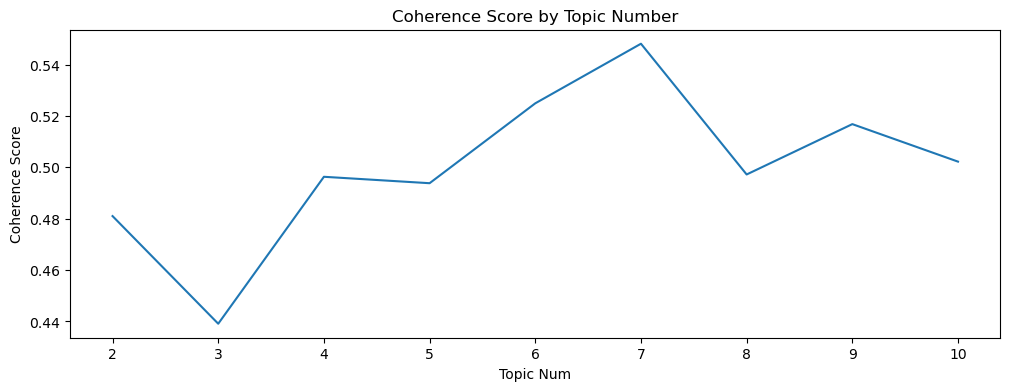

In [242]:
topics_range = list(range(2, 11, 1))
fig = plt.figure(figsize=(12,4))

plt.plot(
    topics_range,
    coherence_scores
)

plt.xlabel("Topic Num")
plt.ylabel("Coherence Score")
plt.title('Coherence Score by Topic Number')
plt.show()

### create gensim nmf model based on the best number of topics

In [243]:
num_topics = 7

In [244]:
%%time
gensim_nmf_model = Nmf(corpus,
                num_topics=num_topics,
                id2word=dictionary,
                chunksize=2000,
                passes=20,
                kappa=.1,
                minimum_probability=0.01,
                w_max_iter=300,
                w_stop_condition=0.0001,
                h_max_iter=100,
                h_stop_condition=0.001,
                eval_every=10,
                normalize=True,
                random_state=42)

dictionary = Dictionary(df_nmf_bigrams['bi_gram'])
dictionary.filter_extremes(no_below=10, no_above=0.6)
corpus = [dictionary.doc2bow(text) for text in df_nmf_bigrams['bi_gram']]

CPU times: user 1min 23s, sys: 7min 43s, total: 9min 7s
Wall time: 19.9 s


In [245]:
def display_gensim_nmf_topics(model, dictionary, no_top_words):
    for topic in range(model.num_topics):
        terms = model.get_topic_terms(topic, topn=no_top_words)
        total = sum([prob for _, prob in terms])
        print("\nTopic %02d" % topic)
        for word_id, prob in terms:
            word = dictionary[word_id]
            print("  %s (%2.2f%%)" %  (word, prob*100.0/total))

In [246]:
# Usage
display_gensim_nmf_topics(gensim_nmf_model, dictionary, 15)


Topic 00
  fuck (90.03%)
  ass (3.97%)
  nigga (2.88%)
  cunt (1.05%)
  eat_shit (0.74%)
  huge (0.45%)
  god_damn (0.30%)
  warn (0.12%)
  nigger (0.08%)
  mother (0.07%)
  die_die (0.07%)
  suck_dick (0.07%)
  bitch (0.06%)
  life_outsid (0.06%)
  ban (0.04%)

Topic 01
  fuck (93.48%)
  peni (3.60%)
  hate (1.33%)
  fat (0.67%)
  shit (0.14%)
  like (0.11%)
  peopl (0.11%)
  ban (0.11%)
  fuc (0.10%)
  bastard (0.09%)
  life (0.07%)
  know (0.06%)
  dont (0.05%)
  gai (0.05%)
  think (0.04%)

Topic 02
  nigga (97.24%)
  like (0.38%)
  dick (0.25%)
  peopl (0.24%)
  think (0.24%)
  time (0.23%)
  suck (0.22%)
  talk (0.18%)
  edit (0.18%)
  good (0.18%)
  know (0.16%)
  faggot (0.13%)
  need (0.13%)
  want (0.13%)
  work (0.12%)

Topic 03
  hate_hate (69.28%)
  shut_fuck (25.01%)
  ass (0.90%)
  edit (0.85%)
  know (0.72%)
  cunt (0.69%)
  think (0.35%)
  like (0.34%)
  time (0.31%)
  peopl (0.30%)
  life (0.27%)
  talk (0.27%)
  stupid (0.27%)
  shit (0.23%)
  hate (0.22%)

Topic 04

In [248]:
def extract_topic_terms(model, dictionary,num_topics, no_top_words):
    
    topics_data = []
    
    for topic in range(model.num_topics):
        terms = model.get_topic_terms(topic, topn=no_top_words)
        total = sum([prob for _, prob in terms])
        terms_list = [(prob*100.0/total, dictionary[word_id]) for word_id, prob in terms]
        avg_coherence = sum([t[0] for t in terms_list]) / no_top_words
        topics_data.append((terms_list, avg_coherence))

    return topics_data

def create_heatmap(model, dictionary, num_topics, num_words):
    top_topics = extract_topic_terms(model, dictionary, num_topics,num_words)
    prob = [f'Topic {idx+1}\n({round(i[1],2)})' for idx, i in enumerate(top_topics)]
    result_lst = []
    annot_lst = []
    for idx, row in enumerate(top_topics):
        result_lst.append([])
        annot_lst.append([])
        for j, k in row[0][:num_words]:
            result_lst[idx].append(round(j,2))
            annot_lst[idx].append(f'''{k}\n{str(round(j,2))}''')

    plt.figure(figsize=(25,7)) 
    plt.title('gesim_nmf top topics with pro')
    sns.heatmap(pd.DataFrame(result_lst), annot=pd.DataFrame(annot_lst), fmt='', cmap='YlGnBu',
               xticklabels = False, yticklabels = prob)
    plt.show()

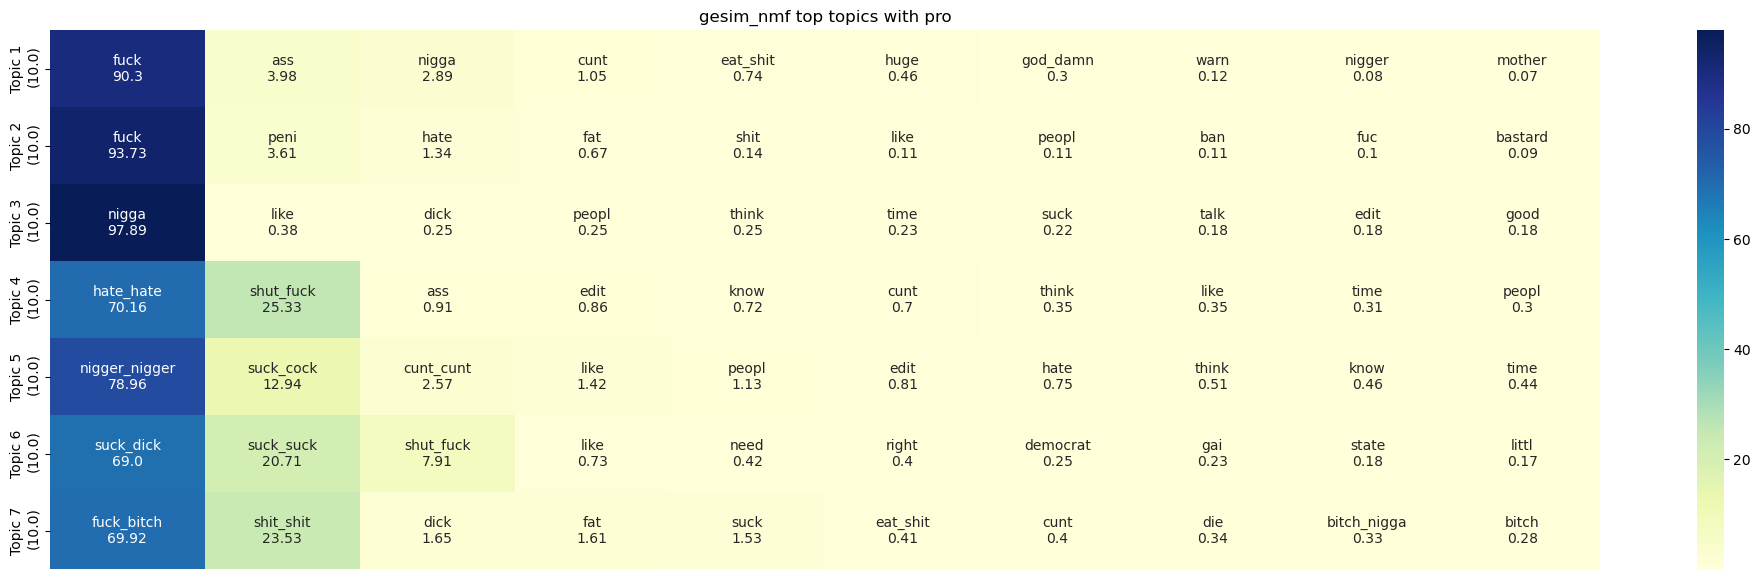

In [249]:
create_heatmap(gensim_nmf_model, dictionary, num_topics=num_topics, num_words=10) 

## Supervised learning

First, let's generate the balanced dataset for training, and add the features extracted from text.

In [57]:
# add additional columns text_len, hashtag_count, mention_count,capital_percentage
def text_len(text):
    return len(text.split())

def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

def count_mentions(text):
    return text.count('@')

def capital_percentage(text):
    if len(text) == 0:
        return 0
    return sum(1 for char in text if char.isupper()) / len(text) * 100

def count_urls(text):
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    return len(urls)

In [58]:
balance_YN = 'Y'
filename_list =['wiki_data', 'kaggle_data', 'twitter_data_relabel',
       'formspring_data','youtube_data']
result_df = select_df(balance_YN, filename_list)
result_df = result_df.copy()
result_df['text_len'] = result_df['text'].apply(text_len)
result_df['hashtag_count'] = result_df['text'].apply(count_hashtags)
result_df['mention_count'] = result_df['text'].apply(count_mentions)
result_df['capital_letter_pct'] = result_df['text'].apply(capital_percentage)
result_df['url_count'] = result_df['text'].apply(count_urls)

In [59]:
result_df.head(2)

text  \
145186                                                               "Let BaseGod fuck your bith man...Let him purge you of that Hate."   
145189  "bitch fuck A e-thug,MOTHER FUCKER im A cold hearted SHAOLIN MONK,and believe me when i tell you THIS,I WILL HUNT YOU DOWN !!!"   

        label     filename split  text_len  hashtag_count  mention_count  \
145186      1  kaggle_data   NaN        12              0              0   
145189      1  kaggle_data   NaN        23              0              0   

        capital_letter_pct  url_count  
145186            7.575758          0  
145189           35.433071          0

In [60]:
result_df[result_df.label==1]['filename'].value_counts()

filename
wiki_data               13568
twitter_data_relabel     5054
kaggle_data              2778
formspring_data           776
youtube_data              417
Name: count, dtype: int64

As we can see, the classes in the dataset are balanced.

label              filename      0      1
3                 wiki_data  13568  13568
2      twitter_data_relabel   5054   5054
1               kaggle_data   2778   2778
0           formspring_data    776    776
4              youtube_data    417    417


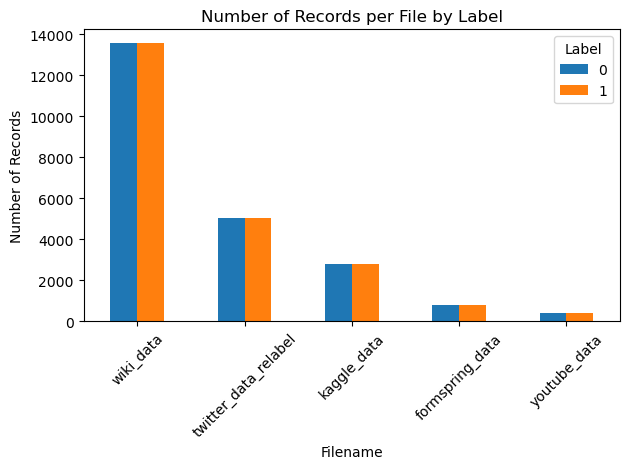

In [61]:
balanced_df = result_df.copy()
show_file_distribution(balanced_df)

We will do train test split, and use stratefied split with data souces (wiki, twitter etc.)

In [62]:
%%time
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
X = balanced_df.loc[:, balanced_df.columns != 'label']
stratify = balanced_df['label'].astype(str) + "_" + balanced_df['filename'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, balanced_df.label, test_size=0.2, random_state=42, stratify=stratify)

print(X_train['filename'].value_counts()/len(X_train['filename']))
print(X_test['filename'].value_counts()/len(X_test['filename']))

print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))
print("Train size "+str(len(y_train)))
print("Test size "+str(len(y_test)))
print("Classes are balanced")

filename
wiki_data               0.600531
twitter_data_relabel    0.223691
kaggle_data             0.122939
formspring_data         0.034359
youtube_data            0.018480
Name: count, dtype: float64
filename
wiki_data               0.600575
twitter_data_relabel    0.223722
kaggle_data             0.123036
formspring_data         0.034300
youtube_data            0.018367
Name: count, dtype: float64
label
0    0.5
1    0.5
Name: count, dtype: float64
label
0    0.5
1    0.5
Name: count, dtype: float64
Train size 36148
Test size 9038
Classes are balanced
CPU times: user 97.5 ms, sys: 10.5 ms, total: 108 ms
Wall time: 167 ms


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wenyuand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
# X_train.head(2)

In [33]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/wenyuand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We will vectorize the text with TFIDF vectorizer

In [64]:
%%time
stop_words = set(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(max_features=3000)

def get_features(X_raw, is_train=False):
    preprocessed_text = X_raw.text.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])
    if is_train:
        X = tfidf_vectorizer.fit_transform(preprocessed_text.str.join(' '))
    else:
        X = tfidf_vectorizer.transform(preprocessed_text.str.join(' '))
    X = np.hstack((X_raw[['text_len', 'hashtag_count', 'mention_count', 'capital_letter_pct', 'url_count']], X.toarray()))
    print(X.shape)
    return X

X_train_final = get_features(X_train, True)
X_test_final = get_features(X_test)

(36148, 3005)
(9038, 3005)
CPU times: user 19.5 s, sys: 1.58 s, total: 21.1 s
Wall time: 21.1 s


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

Define a function to evaluate the models with F1 scores. We will calculate the F1 scores on both train and test data, to detect overfitting.

In [42]:
def evaluate(best_para, y_test, y_pred, y_train, y_train_pred):
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Best Parameters:", best_para)
    print("F1 of training data:", f1_score(y_train, y_train_pred))
    print("F1 of testing data:", f1_score(y_test, y_pred))

First, we will train a LASSO regression model. GridSearchCV will be used for cross validation.

In [48]:
%%time
param_grid_l1 = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1'],
    'solver': ['liblinear', 'saga']
}

# Define a logistic regression classifier
clf_logreg = LogisticRegression(max_iter=10000, tol=1e-3, random_state=random_state)
# Use GridSearchCV with cross-validation
grid_search_logreg = GridSearchCV(clf_logreg, param_grid=param_grid_l1, cv=5, scoring='f1', n_jobs=-1, verbose=10)
grid_search_logreg.fit(X_train_final, y_train)

# Retrieve the best hyperparameters and the associated best score
best_parameters_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_

# Predict on test set using the best model
best_model_l1 = LogisticRegression(**best_parameters_logreg)
best_model_l1.fit(X_train_final, y_train)
y_train_pred = best_model_l1.predict(X_train_final)
y_pred = best_model_l1.predict(X_test_final)

evaluate(best_parameters_logreg, y_test, y_pred, y_train, y_train_pred)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


IOStream.flush timed out


[CV 5/5; 1/8] START C=0.01, penalty=l1, solver=liblinear........................
[CV 5/5; 1/8] END C=0.01, penalty=l1, solver=liblinear;, score=0.472 total time=   1.4s
[CV 4/5; 1/8] START C=0.01, penalty=l1, solver=liblinear........................
[CV 4/5; 1/8] END C=0.01, penalty=l1, solver=liblinear;, score=0.476 total time=   1.2s
[CV 1/5; 5/8] START C=1, penalty=l1, solver=liblinear...........................
[CV 1/5; 5/8] END C=1, penalty=l1, solver=liblinear;, score=0.806 total time=   1.4s
[CV 2/5; 5/8] START C=1, penalty=l1, solver=liblinear...........................
[CV 2/5; 5/8] END C=1, penalty=l1, solver=liblinear;, score=0.812 total time=   1.4s
[CV 3/5; 5/8] START C=1, penalty=l1, solver=liblinear...........................
[CV 3/5; 5/8] END C=1, penalty=l1, solver=liblinear;, score=0.816 total time=   1.3s
[CV 3/5; 3/8] START C=0.1, penalty=l1, solver=liblinear.........................
[CV 3/5; 3/8] END C=0.1, penalty=l1, solver=liblinear;, score=0.748 total time=   1

Then, let's try Ridge regression and see how l2 regularization works comparing to l1.

In [50]:
%%time
param_grid_l2 = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Define a logistic regression classifier
clf_logreg = LogisticRegression(max_iter=10000, tol=1e-3, random_state=random_state)
# Use GridSearchCV with cross-validation
grid_search_logreg = GridSearchCV(clf_logreg, param_grid=param_grid_l2, cv=5, scoring='f1', n_jobs=-1)
grid_search_logreg.fit(X_train_final, y_train)

# Retrieve the best hyperparameters and the associated best score
best_parameters_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_

# Predict on test set using the best model
best_model_l2 = LogisticRegression(**best_parameters_logreg)
best_model_l2.fit(X_train_final, y_train)
y_train_pred = best_model_l2.predict(X_train_final)
y_pred = best_model_l2.predict(X_test_final)
evaluate(best_parameters_logreg, y_test, y_pred, y_train, y_train_pred)

[CV 3/5; 4/8] START C=0.1, penalty=l1, solver=saga..............................
[CV 3/5; 4/8] END C=0.1, penalty=l1, solver=saga;, score=0.534 total time=13.8min
[CV 5/5; 1/4] START C=0.01, penalty=l1, solver=liblinear........................
[CV 5/5; 1/4] END C=0.01, penalty=l1, solver=liblinear;, score=0.472 total time=   1.2s
[CV 5/5; 4/4] START C=10, penalty=l1, solver=liblinear..........................
[CV 5/5; 4/4] END C=10, penalty=l1, solver=liblinear;, score=0.793 total time=   1.7s
[CV 1/5; 4/4] START C=10, penalty=l1, solver=liblinear..........................
[CV 1/5; 4/4] END C=10, penalty=l1, solver=liblinear;, score=0.799 total time=   1.7s
[CV 2/5; 6/8] START C=1, penalty=l1, solver=saga................................
[CV 2/5; 6/8] END .C=1, penalty=l1, solver=saga;, score=0.571 total time=17.0min
[CV 2/5; 3/4] START C=1, penalty=l1, solver=liblinear...........................
[CV 2/5; 3/4] END C=1, penalty=l1, solver=liblinear;, score=0.812 total time=   1.3s
[CV 4/

Looks like the accuraccy of Ridge regression is slightly worse than LASSO regression. The good thing is that there is no significant overfitting.
Next, we will try a Random Forest model:

In [61]:
%%time
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 50, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define a random forest classifier
clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use GridSearchCV with cross-validation
grid_search_rf = GridSearchCV(clf_rf, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_final, y_train)

# Retrieve the best hyperparameters and the associated best score
best_parameters_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Predict on test set using the best model
best_model_rf = RandomForestClassifier(**best_parameters_rf)
best_model_rf.fit(X_train_final, y_train)
y_train_pred = best_model_rf.predict(X_train_final)
y_pred = best_model_rf.predict(X_test_final)
evaluate(best_parameters_rf, y_test, y_pred, y_train, y_train_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      4519
           1       0.83      0.79      0.81      4519

    accuracy                           0.82      9038
   macro avg       0.82      0.82      0.82      9038
weighted avg       0.82      0.82      0.82      9038

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
F1 of training data: 0.9919225449515906
F1 of testing data: 0.8112714464265425
CPU times: user 4min 18s, sys: 7.01 s, total: 4min 25s
Wall time: 19min 27s


We observed overfitting! Let's try reducing it by limiting the max depth of trees:

In [63]:
%%time
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [10, 50, 80],
    'max_features': ['sqrt', 'log2']
}

# Define a random forest classifier
clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use GridSearchCV with cross-validation
grid_search_rf = GridSearchCV(clf_rf, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_final, y_train)

# Retrieve the best hyperparameters and the associated best score
best_parameters_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Predict on test set using the best model
best_model_rf = RandomForestClassifier(**best_parameters_rf)
best_model_rf.fit(X_train_final, y_train)
y_train_pred = best_model_rf.predict(X_train_final)
y_pred = best_model_rf.predict(X_test_final)
evaluate(best_parameters_rf, y_test, y_pred, y_train, y_train_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81      4519
           1       0.82      0.77      0.80      4519

    accuracy                           0.80      9038
   macro avg       0.81      0.80      0.80      9038
weighted avg       0.81      0.80      0.80      9038

Best Parameters: {'max_depth': 80, 'max_features': 'log2', 'n_estimators': 300}
F1 of training data: 0.9389629045432781
F1 of testing data: 0.797393093985822
CPU times: user 2min 43s, sys: 5.38 s, total: 2min 49s
Wall time: 3min 52s


From the example above, the overfitting can be reduced if we limit max depth of trees. However, the test F1 score also reduced, so we may not be able to achieve better F1 score with Random Forest.

Next, we will try using the XGBoost classifier. Due to limitation of time, we will not use cross validation for the models below. Instead, we further split the training data into train and validation datasets:

To optimize processing speed, we will use multi-threading and GPU to train models for different hyperparameters:

In [ ]:
%%time
import xgboost as xgb
from tqdm import tqdm
from multiprocessing.dummy import Pool
from itertools import product
def train_xgb_model(params):
    # Unpack hyperparameters
    X_train_xgb, X_vali_xgb, y_train_xgb, y_vali_xgb = train_test_split(X_train_final, y_train, test_size=0.2, random_state=42)
    n_estimators, learning_rate, max_depth, min_child_weight, subsample,colsample_bytree, gamma, scale_pos_weight  = params
    
    # Create and train the Random Forest classifier
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            gamma=gamma,
                            scale_pos_weight=scale_pos_weight,
                            device="cuda",
                            random_state=42)
    
    # Fit the model to your training data
    xgb_clf.fit(X_train_xgb, y_train_xgb)
    
    return xgb_clf

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of a tree
    'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
    'scale_pos_weight': [1, 2, 3]  # Controls the balance of positive and negative weights
}

# param_grid = {
#     'n_estimators': [1],  # Number of boosting rounds
#     'learning_rate': [0.01],  # Step size shrinkage used in update to prevent overfitting
#     'max_depth': [3],  # Maximum depth of a tree
#     'min_child_weight': [1],  # Minimum sum of instance weight (hessian) needed in a child
#     'subsample': [0.8],  # Fraction of samples used for fitting the trees
#     'colsample_bytree': [0.8],  # Fraction of features used for fitting the trees
#     'gamma': [0],  # Minimum loss reduction required to make a further partition on a leaf node
#     'scale_pos_weight': [1]  # Controls the balance of positive and negative weights
# }


param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['min_child_weight'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['gamma'],
    param_grid['scale_pos_weight']
))

num_threads = 30
with Pool(num_threads) as pool:
    trained_models = list(tqdm(pool.imap(train_xgb_model, param_combinations), total=len(param_combinations)))


XGBoost classifier is known to be hard to tune. We have been trying different hyperparameters, and store them with the code below:

In [ ]:
import multiprocessing
from sklearn.metrics import f1_score
import pickle

def calculate_f1_score(model):
    y_pred = model.predict(X_vali_xgb)
    f1 = f1_score(y_vali_xgb, y_pred)
    return f1

num_cpu = 38
with Pool(num_cpu) as pool:
    f1_scores = list(tqdm(pool.imap(calculate_f1_score, [(model) for model in trained_models]), total=len(trained_models)))
                 
best_model_index = f1_scores.index(max(f1_scores))
best_model_xgb = trained_models[best_model_index]

file_name = "xgb_clf_best.pkl"

# save
pickle.dump(best_model_xgb, open(file_name, "wb"))

The below model is the best we found so far. However, it's performance is not significantly better than the previous models:

In [83]:
import pickle
file_name = "xgb_clf_best.pkl"

# save
# pickle.dump(best_xgb, open(file_name, "wb"))
# best_xgb.score(X_test_final, y_test)

with open(file_name, 'rb') as model_file:
    best_model_xgb = pickle.load(model_file)
    y_train_pred = best_model_xgb.predict(X_train_final)
    y_pred = best_model_xgb.predict(X_test_final)
    evaluate(best_model_xgb.get_params(), y_test, y_pred, y_train, y_train_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83      4519
           1       0.87      0.74      0.80      4519

    accuracy                           0.82      9038
   macro avg       0.82      0.82      0.82      9038
weighted avg       0.82      0.82      0.82      9038

Best Parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_est

To further improve the model performance, we will use a Bert model which is known to work well for many NLP tasks.

In [37]:
%%time
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# def get_encoded(X_raw, is_train=False):
#     preprocessed_text = X_raw.text.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])
#     if is_train:
#         X = tfidf_vectorizer.fit_transform(preprocessed_text.str.join(' '))
#     else:
#         X = tfidf_vectorizer.transform(preprocessed_text.str.join(' '))
print(X_train.text.values)

X_train_encoded = tokenizer(X_train.text.values.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
X_validation_encoded = tokenizer(X_validation.text.values.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
X_test_encoded = tokenizer(X_test.text.values.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

['hey ,muslim dickhead !!!!!!!! why don;t you go and shove allah or whatever the fuck you call the retard up your stupid backwards ass !!!!!!!!! you fucking muslims are a bunch of jealous west hating mongs, islam is a peaceful religion, bullshit !!!!!!! there are many times when it refers to violence. so go strap on your suicide bomb and blow yourself up. yey, one less feeble minded prick ion the world.'
 '== good job! ==  that user cumulus clouds hacks articles apart without reading the references. he removes information without doing anything to improve an article. you, on the other hand, do a great deal to make things better and more interesting... after all, wiki is not supposed to put people to sleep... it is intended to be informative cumulus clouds does not seem to understand this. thank you and well done.'
 "`, 31 october 2011 (utc) :are you fucking stupid? do you have brain damage? i just clearly told why you have no fucking right to demand civility from people. you can't actu

In [93]:
%%time
from tqdm import tqdm
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_encoded = tokenizer(X_train.text.values.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
train_data = torch.utils.data.TensorDataset(X_train_encoded['input_ids'], X_train_encoded['attention_mask'], torch.tensor(y_train.values.tolist()))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

### hyper parameters:
learning_rate = 2e-5
epochs = 10
### hyper parameters end


optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda")
model.to(device)
print("device is: ")
print(device)


for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
    
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

device is: 
cuda


Epoch 1/10, Loss: 0.3232


Epoch 2/10, Loss: 0.2147


Epoch 3/10, Loss: 0.1391


Epoch 4/10, Loss: 0.0887


Epoch 5/10, Loss: 0.0608


Epoch 6/10, Loss: 0.0424


Epoch 7/10, Loss: 0.0336


Epoch 8/10, Loss: 0.0253


Epoch 9/10, Loss: 0.0227


Epoch 10/10, Loss: 0.0205
CPU times: user 40min 55s, sys: 8.4 s, total: 41min 3s
Wall time: 41min 2s


## The below code is for saving/loading the trained model

In [94]:
torch.save(model.state_dict(), 'bert1.pth')

In [89]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_test_encoded = tokenizer(X_test.text.values.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
test_data = torch.utils.data.TensorDataset(X_test_encoded['input_ids'], X_test_encoded['attention_mask'], torch.tensor(y_test.values.tolist()))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

# Load the saved model state_dict into the model
model.load_state_dict(torch.load('bert.pth'))
device = torch.device("cuda")
model.to(device)
# Put the model in evaluation mode
model.eval()
all_preds = []
all_labels = []
progress_bar = tqdm(test_loader, desc="Validation", leave=False)
for batch in progress_bar:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

f1_value = f1_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)
print(f"F1 score: {f1_value:.4f}")
print(report)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

F1 score: 0.8913
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      4519
           1       0.82      0.98      0.89      4519

    accuracy                           0.88      9038
   macro avg       0.90      0.88      0.88      9038
weighted avg       0.90      0.88      0.88      9038



As we can see, the Bert model has the best performance. We only trained it for 10 epoches due to limited time, and we may get better f1-score if more epoches are trained.

# Backup